# Capstone project 2: Application Recommendation System for Biodegradable Polymer

**Problem and Goal:**  
Developing new applications of a polymer is one of the most important and challenging steps to sell a polymer as a product. It requires a wide range of knowledge about polymer itself (physical property, formability, etc.) and products that might already exist or might not yet. The goal of this project is to make an application recommendation system that gives some hints about potential applications for a given polymer by a user. A biodegradable polymer has been chosen as a polymer kind for this project.

## Table of Contents

1. Load Data  
2. Exploratory Data Analysis  
3. Data Wrangling  
4. Modeling  
5. Recommend Applications (using the Model)

## 1. Load Data

Patents are used to make the recommendation system. A patent includes information about what polymer was used, how to prepare it, for what it could be used, who invented it, and so on. The material and application data would provide useful information for this project.  
  
  
The patent data was acquired from the database of the [World Intellectual Property Organization (WIPO)](https://patentscope.wipo.int/search/en/search.jsf) with a search word “IC:(C08L 101/16)”. The dataset includes patents categorized into "C08B 101/16" and released by Jun.2.2020. C08L 101/16 is the IPC code (International Patent Classification code) for biodegradable polymers. IPC is a hierarchical patent classification system. All technical fields are divided into 8 "sections" from A to H:  
  
-A: Human Necessities  
-B: Performing Operations, Transporting  
-C: Chemistry, Metallurgy  
-D: Textiles, Paper  
-E: Fixed Constructions  
-F: Mechanical Engineering, Lighting, Heating, Weapons, Blasting  
-G: Physics  
-H: Electricity  
  
There are "classes" in each section, and each class has "subclasses". Then, there are "maingroups" under a subclass, and finally "subgroups".  For example, C08L 101/16 means:  
  
(Section)   C: Chemistry, Metallurgy  
(Class)     C08: Organic macromolecular compounds, Preparation or chemical working-up    
(Subclass)  C08L: Macromolecular compounds  
(Maingroup) C08L 101: Unspecified macromolecular compounds  
(Subgroup)  C08L 101/16: Biodegradable macromolecular compounds  
  
Each IPC code represents a material, application, or technology to manufacture it. The patent information in WIPO is collected from [193 member countries](https://www.wipo.int/members/en/). The coverage is [wide](https://patentscope.wipo.int/search/en/help/data_coverage.jsf), but not exhaustive. 
  
  
Load the data and check the general information.

In [1]:
# Import the packages
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from collections import Counter
import itertools
import re
from fastText import load_model
from iso_language_codes import *
from googletrans import Translator
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import nxviz as nv
import csv

# Import a pre-trained model for language identification (from fastText)
li_model = load_model("lid.176.bin")

# Set a style for a plot
sns.set(context='notebook', style='ticks', palette='hls')
pd.set_option("display.max_colwidth", 100)

In [2]:
# You can see this notebook without codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Load the csv file 
raw_data_file = 'C08L10116_csv.csv'
df= pd.read_csv(raw_data_file)

print('Raw data')
print('df (first row):')
df.head(1)

Raw data
df (first 5 rows):


,Application Id,Application Number,Application Date,Country,Title,Abstract,I P C,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


In [4]:
# Rename the column names
df = df.rename(columns={'Application Id': 'Patent_Id', 
                        'Application Number': 'Application_Number', 
                        'Application Date': 'Application_Date',
                        'I P C': 'IPC'})

print('Raw data after renaming the columns')
print('df (first 5 rows):')
df.head()

Raw data after renaming the columns
df (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


This dataset includes worldwide patents, and the language is not limited in English. 

In [6]:
# Check the general information
print('The general information of "df":')
df.info()

The general information of "df":
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Patent_Id           8182 non-null   object
 1   Application_Number  8135 non-null   object
 2   Application_Date    8165 non-null   object
 3   Country             8182 non-null   object
 4   Title               8172 non-null   object
 5   Abstract            7604 non-null   object
 6   IPC                 8182 non-null   object
 7   Applicants          8025 non-null   object
 8   Inventors           8027 non-null   object
dtypes: object(9)
memory usage: 575.4+ KB


This dataset includes 8,182 patents. The five columns other than 'Patent_Id', 'Country', and 'IPC' have missing data.

In [8]:
# Check duplicate rows and application IDs
print('The number of duplicate rows:', list(df.duplicated()).count(True))
print('The number of duplicate Patent_Ids:', list(df['Patent_Id'].duplicated()).count(True))

The number of duplicate rows: 0
The number of duplicate Patent_Ids: 0


Each row is unique, and there is no duplicate patent ID. 

## 2. Exploratory Data Analysis

Before starting to prepare for the modeling, take a look at the data to know what should be in mind.

2.1. Countries patents were filed in    
2.2. Explore IPC codes  
2.3. Popular polymers  
2.4. Popular applications (big category)  
2.5. Popular applications in the medical category (A61)  
2.6. Language variety

### 2.1. Countries patents were filed in

The 'Country' column in the data shows which country a patent was registered in. It would be connected to the market. Check the country variety and which countries are frequent.

(I will add **UNIT TEST** here later:  df['Country'] doesn't have missing values.)

In [12]:
# How many countries
print('The number of countries:', df['Country'].nunique(), 'countries')

The number of countries: 37 countries


<IPython.core.display.Javascript object>


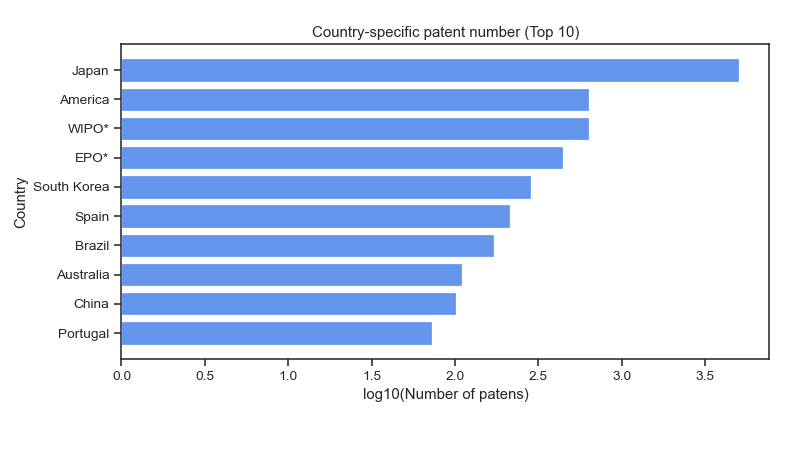

In [436]:
# Count the total patent number of each country
patent_byCountry = Counter(df['Country']).most_common()

# Extract the top 10 countries and the numbers of patents, and reverse the orders
top10_countries_list = list(reversed(patent_byCountry[:10]))

# Prepare an abbreviation dictionary
abbre_country_dict = {'JP': 'Japan',
                      'US': 'America',
                      'WO': 'WIPO*',
                      'EP': 'EPO*',
                      'KR': 'South Korea',
                      'ES': 'Spain',
                      'BR': 'Brazil',
                      'AU': 'Australia',
                      'CN': 'China',
                      'PT': 'Portugal'}

# Draw a bar plot of the top 10 countries
plt.figure(figsize=(9,5))

x_count = [np.log10(country[1]) for country in top10_countries_list]
y_abbreCountry = [country[0] for country in top10_countries_list]
y_country = [abbre_country_dict[abb] for abb in y_abbreCountry]

plt.barh(y_country, x_count, color='cornflowerblue')

plt.xlabel('log10(Number of patens)')
plt.ylabel('Country')
plt.title('Country-specific patent number (Top 10)')

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.90)
plt.show()

* WIPO = World Intellectual Property Organization  
* EPO = European Patent Office

The patent data is from 37 countries (and organizations). Japan and America are the largest groups. The recommended applications by the system will tend to be for products that are popular in those countries.

### 2.2. Explore IPC Codes

The DataFrame 'df' has a column called 'IPC.' This column shows the IPC codes the patent is categorized in. In this section, the following three points are explored.

2.2.1. Number of IPC codes per patent  
2.2.2. Number of IPC code kinds  
2.2.3. Frequency of each IPC code in data

#### 2.2.1. Number of IPC codes per patent 

The number of IPC codes per patent is directly related to the number of connections with other patents. If a patent has many connections with other patents, the patent is more likely to appear in the searching result. 

(I will add **UNIT TEST** here later:  df['IPC'] doesn't have missing values.)

In [16]:
# A dictionary to store the Application_Id and the IPC codes
patent_ipc_dict = {}

# Store patent IDs and the IPC codes in the dictionary
for i in range(len(df)):
    # Extract the IPC codes
    ipcs = df.loc[i, 'IPC']
    
    # Split the IPC codes and keep them in a set
    ipc_set = set(re.findall('[A-Z][0-9]+[A-Z][ ][0-9]+/[0-9]+', ipcs))
    
    # Remove 'C08L 101/16' (because all patents have this IPC code)
    ipc_set.remove('C08L 101/16')
    
    # Add the ipc_set in the patent_ipc_dict
    patent_ipc_dict[df.loc[i, 'Patent_Id']] = ipc_set

<IPython.core.display.Javascript object>


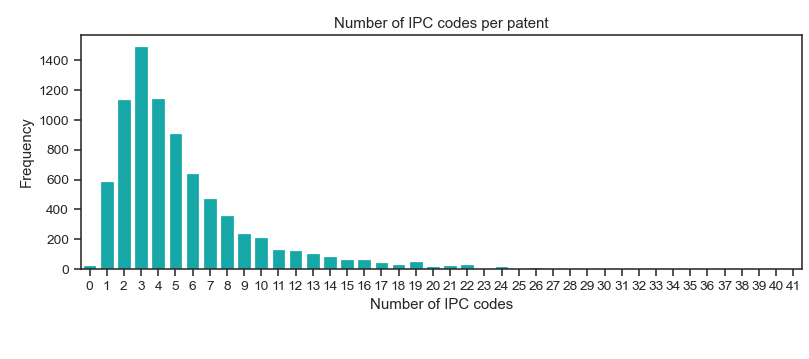

In [437]:
# Count the number of IPC codes per patent
numIpcs_perPatent_list = list(map(lambda ipcs: len(ipcs), patent_ipc_dict.values()))

# Draw a count plot
plt.figure(figsize=(9,4))

sns.countplot(x=numIpcs_perPatent_list, color='c')
plt.ylabel('Frequency')
plt.xlabel('Number of IPC codes')
plt.title('Number of IPC codes per patent')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.25, top=0.90)
plt.show()

The peak of the distribution was 3. Some patents do not have any IPC codes (other than 'C08L 101/16'). They do not have any connection when the network is drawn. Check if the patents have an abstract so that it can be used to search the relationships with other patents. 

In [19]:
# Get the Patent_Ids of patents not having any IPC code 
noIpc_patents_list = [k for k, v in patent_ipc_dict.items() if len(v) == 0]

# Show the 'df' rows of the patents
print('Patents having only "C08L 101/16" as an IPC code:')
print(len(df[df['Patent_Id'].isin(noIpc_patents_list)]), 'patents')
df[df['Patent_Id'].isin(noIpc_patents_list)]

Patents having only "C08L 101/16" as an IPC code:
25 patents


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
229,MX236552233,2017005889,04.05.2017,MX,SÍNTESIS DE UN COPOLÍMERO INJERTO BIODEGRADABLE CAPAZ DE FORMAR PELÍCULA DE BAJA ADSORCIÓN.,The present invention discloses the synthesis of a biodegradable graft copolymer of low adsorpti...,C08L 101/16,UNIVERSIDAD DE GUANAJUATOUNIVERSIDAD DE GUANAJUATO,José Luis MATA MATA; Aurelio RAMÍREZ HERNÁNDEZ; Alejandro APARICIO SAGUILAN
651,MY203067723,PI 2014002784,29.09.2014,MY,A PROCESS FOR FULLY COMPOSTING BIODEGRADABLE HIGH PERFORMANCE PLASTIC MATERIALS,THE PRESENT INVENTION PROVIDES A PROCESS FOR FULLY COMPOSITING BIODEGRADABLE HIGH PERFORMANCE PL...,C08L 101/16,HENG HIAP INDUSTRIES SDN BHD,SEAH KIAN HOE
1214,CN85366070,201210198111.9,15.06.2012,CN,Production method of biodegradable medical plastics,The invention discloses a production method of environment-friendly biodegradable medical plasti...,C08L 101/16,"Yancheng Jinwo Medical Technology Co., Ltd.",Wang Jun
1477,MX130518126,2011008209,04.08.2011,MX,"PROCESO PARA LA ELABORACIÓN DE PELÍCULAS A PARTIR DE CÍTRICOS, LAS PELÍCULAS Y SU USO COMO EMPAQ...","The present invention refers to a process for the manufacture of films from citrus, the films an...",C08L 101/16,INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREYINSTITUTO TECNOLOGICO Y DE ESTUDIOS S...,HUGO MUJICA PAZ; JOCELIN GABRIELA HERNANDEZ CARRILLO; JORGE WELTI CHANES; AURORA VALDEZ FRAGOSO
1631,ID202886819,P00201100008,06.01.2011,ID,SUATU MATERIAL BARU FILM PLASTIK MESRA ALAM CAMPURAN POLI (3-HIDROKSI BUTIRAT) DENGAN POLISTIREN,Suatu material baru berupa filem plastik ramah lingkungan terbuat dari campuran polistiren(PS) d...,C08L 101/16,Prof. Dr. Akmal Djamaan,Akmal Djamaan
2132,AR10512058,P090102894,29.07.2009,AR,MATERIAL COMPUESTO QUE CONTIENE MATERIAL TERMOPLASTICO Y MATERIAL PROTEINICO Y PROCEDIMIENTO DE ...,"Material compuesto que contiene material termoplástico y material proteínico, y proceso de obten...",C08L 101/16,PETROLEO BRASILEIRO S.A. - PETROBRAS -,"JURITI NAZARETH, NICOLAS; SOARES RIBEIRO, CLAUDIA MARIA; LOPES DIAS, MARCOS; MARTINS CUNHA, LAIN..."
2367,WO2009074723,PCT/FI2008/050733,12.12.2008,WO,NATURAL FIBRE BASED COMPOSITE MATERIAL,"A natural fibre based, melt processable composite material comprising a polymer matrix of a biod...",C08L 101/16,"VALTION TEKNILLINEN TUTKIMUSKESKUS; LAMPINEN, Johanna; IMMONEN, Kirsi","LAMPINEN, Johanna; IMMONEN, Kirsi"
2762,BR6371648,PI0705007-0,17.12.2007,BR,MISTURA POLIMÉRICA INJETÁVEL COM PROPRIEDADES BIODEGRADÁVEIS E PROCESSO PARA SUA OBTENÇÃO,Mistura polimérica injetável com propriedades biodegradáveis e Processo para sua obtenção. A pre...,C08L 101/16,Fundação Universidade de Caxias do Sul,Jadison Fabricio de Souza; Adriana Del Carmen Escalona Gower; Mára Zeni Andrade
2793,KR4235275,1020070121872,28.11.2007,KR,WOOD POWDER COMPOSITION FOR MOLDING WITH IMPROVED DIMENSIONAL STABILITY BY PREVENTING BENDING OR...,PURPOSE: A wood powder composition for molding is provided to reduce the danger of environmental...,C08L 101/16,"JUNG, HAE GYUN; KIM, MI YE; 정해균; 김미애","JUNG, HAE GYUN; 정해균; KIM, MI YE; 김미애"
2898,KR4045656,1020070081054,13.08.2007,KR,"MOLDING MATERIAL HAVING IMPROVED HEAT RESISTANCE, SHAPE-RETAINING PROPERTY, FLEXIBILITY, AND MOL...",PURPOSE: A molding material is provided to be formed into a desired shape by many molding method...,C08L 101/16,"SUMITOMO ELECTRIC FINE POLYMER, INC.; 스미토모덴코파인폴리머 가부시키가이샤",KANAZAWA SHINICHI; 카나자와 신이치


24 patents have only "C08L 101/16" as an IPC code, and one patent has an incomplete code and "C08L 101/16". 20 out of 25 patents have an English abstract, and the abstracts would be used to calculate the similarities to other patents. They will still be active in the system. On the other hand, the remaining 5 patents (ID202886819, AR10512058, BR6371648, KR149646441, and DE104259751) will never show up in the result even though the information is in the network data.  

#### 2.2.2. Number of IPC code kinds

In [21]:
# Flatten the values of patent_ipc_dict (using itertools library)
all_ipcs_list = list(itertools.chain.from_iterable(patent_ipc_dict.values()))

# Count the IPC codes
ipc_freq = Counter(all_ipcs_list)

print('The number of IPC code kinds:', len(ipc_freq))

The number of IPC code kinds: 4344


There are 4,344 kinds of IPC codes in the data. Each IPC code represents a material, application, or technology to manufacture it. When the network is created, the 4,344 IPC codes will be one kind of the nodes. Another kind of nodes will be patents (8,182). That is, the network will have 12,526 nodes in total. 

#### 2.2.3. Frequency of each IPC code in data

Here, the frequency of each IPC code is analyzed. Some IPC codes are very frequent, and some are not. This is connected with the number of edges of the network.

In [22]:
# Sort the dictionary by the frequency
ipc_freq_sorted = dict(sorted(ipc_freq.items(), key=lambda x: x[1], reverse=True))
ipc_freq_sorted_values = list(ipc_freq_sorted.values())               

print('The frequency distribution of IPC codes:')
# Show the summary statistics as a DataFrame
pd.DataFrame(pd.Series(ipc_freq_sorted_values).describe()).transpose()

The frequency distribution of IPC codes:


,count,mean,std,min,25%,50%,75%,max
0,4344.0,10.592081,60.43464,1.0,1.0,2.0,6.0,2830.0


In [25]:
# The number of IPC codes appearing only once
print('The number of IPC codes appearing only once:', ipc_freq_sorted_values.count(1))

# Percentage of IPC codes having one connection 
print('The percentage of IPC codes appearing once:', 
      round(ipc_freq_sorted_values.count(1)/len(ipc_freq)*100, 1), '%')

The number of IPC codes appearing only once: 1665
The percentage of IPC codes appearing once: 38.3 %


<IPython.core.display.Javascript object>


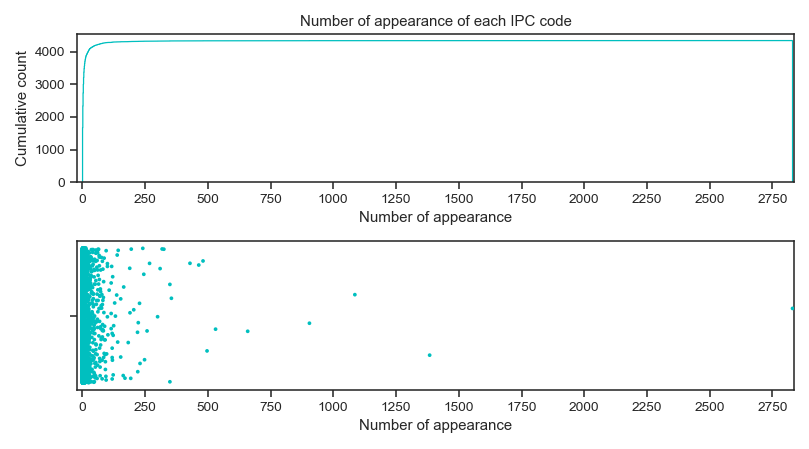

In [175]:
# Draw a count plot and a strip plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(ipc_freq_sorted_values, bins=2830, cumulative=True, histtype='step', color='c')
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')
plt.ylabel('Cumulative count')
plt.title('Number of appearance of each IPC code')

plt.subplot(2,1,2)
sns.stripplot(x=ipc_freq_sorted_values, size=3, color='c', jitter=True) 
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


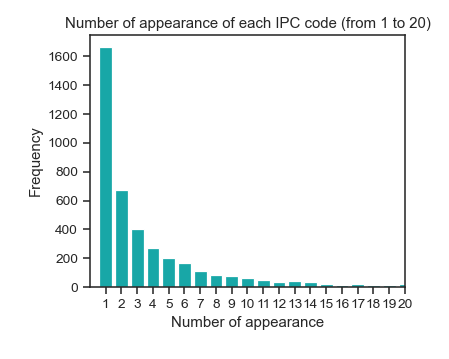

In [438]:
# Draw a bar plot of the number of appearance of each IPC code (from 1 to 20)
plt.figure(figsize=(5,4))

sns.countplot(x=ipc_freq_sorted_values, color='c')
plt.xlim([-1,19])
plt.ylabel('Frequency')
plt.xlabel('Number of appearance')
plt.title('Number of appearance of each IPC code (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

In [28]:
# Check the IPC codes of the top 10 appearance
print('The frequent IPC codes (Top 5):')
ipc_freq.most_common(5)

The frequent IPC codes (Top 5):


[('C08L 67/04', 2830),
 ('C08L 101/00', 1384),
 ('C08L 67/00', 1086),
 ('C08J 5/18', 905),
 ('C08L 67/02', 659)]

- C08L 67/04: Polyesters derived from hydroxy carboxylic acids (e.g. lactones)  
- C08L 101/00: Unspecified macromolecular compounds  
- C08L 67/00: Polyesters obtained by reactions forming a carboxylic ester link in the main chain  
- C08J 5/18: Manufacture of films or sheets      
- C08L 67/02: Polyesters derived from dicarboxylic acids and dihydroxy compounds   

1,665 (38%) IPC codes appear only once. It means they are not much useful to predict applications because the network ends at the IPC codes. However, a user might input the IPC codes and want to start from them to find other applications. So keep them. On the other hand, at least 5 IPC codes appear more than 600 times. This means there are more than 600 connections once reaching the IPC codes. To prioritize the applications, using the similarities of abstracts would be the key. 

### 2.3. Popular polymers

Here, I extract the subclasses representing polymers, that is, 'C08L'. Then, the maingroups are counted to identify the popular polymers in the dataset. The maingroups of 'C08L' represent a polymer kind. For example, 'C08L 1' is 'cellulose', and 'C08L 67' is 'polyesters'. There are two more nested categories indicated after '/', but use the maingroup category (until just before '/') in this section.  

Extract IPC codes beginning with 'C08L'.

In [29]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
C08L_count_dict = {}

# Extract keyes having 'C08L' and the values
for k, v in ipc_freq.items():
    if k[:4] == 'C08L':
        ipc_maingroup = re.search('C08L [0-9]+', k).group()
        if ipc_maingroup in C08L_count_dict.keys():
            C08L_count_dict[ipc_maingroup] += v
        else:
            C08L_count_dict[ipc_maingroup] = v

# Sort by the frequency
C08L_count_dict_sorted = sorted(C08L_count_dict.items(), key=lambda x:x[1]) 

# Show how many kinds of polymers are in the data
print('The number of polymer kinds:', len(C08L_count_dict_sorted))

The number of polymer kinds: 49


<IPython.core.display.Javascript object>


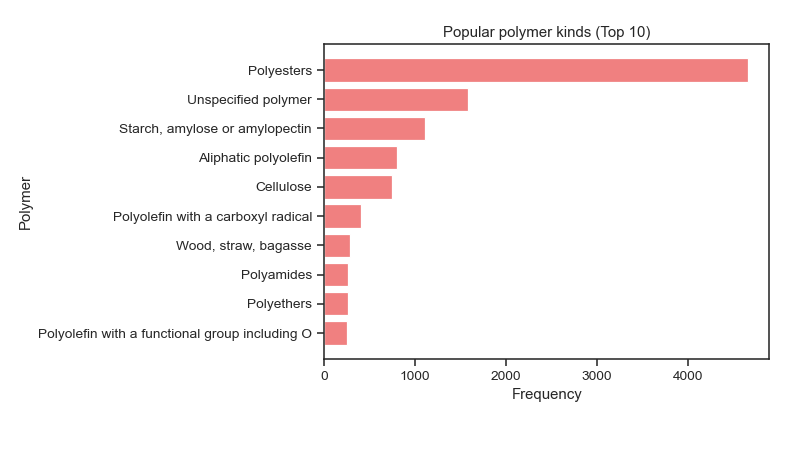

In [439]:
# Prepare a code_name dictionary
abbre_polymer_dict = {'C08L 67': 'Polyesters',
                      'C08L 101': 'Unspecified polymer',
                      'C08L 3': 'Starch, amylose or amylopectin',
                      'C08L 23': 'Aliphatic polyolefin',
                      'C08L 1': 'Cellulose',
                      'C08L 33': 'Polyolefin with a carboxyl radical',
                      'C08L 97': 'Wood, straw, bagasse',
                      'C08L 77': 'Polyamides',
                      'C08L 71': 'Polyethers',
                      'C08L 29': 'Polyolefin with a functional group including O'}

# Draw a bar plot of the top 10 polymers
plt.figure(figsize=(9,5))

x_counts = [tup[1] for tup in C08L_count_dict_sorted[-10:]]
top10_polymers = [tup[0] for tup in C08L_count_dict_sorted[-10:]]
y_polymers = [abbre_polymer_dict[abb] for abb in top10_polymers]

plt.barh(y_polymers, x_counts, color='lightcoral')

plt.xlabel('Frequency')
plt.ylabel('Polymer')
plt.title('Popular polymer kinds (Top 10)')

plt.subplots_adjust(left=0.4, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are 49 kinds of polymers in the data, and polyesters are the most popular.  

### 2.4. Popular applications (big category)

First, I need to decide what IPC codes are treated as applications. I carefully checked the IPC classes and extracted the following IPC classes as applications.

### < IPC Classes for Applications >
**A: HUMAN NECESSITIES** (all classes)   
  
**B: PERFORMING OPERATIONS; TRANSPORTING** (following classes)  
- B09: DISPOSAL OF SOLID WASTE, RECLAMATION OF CONTAMINATED SOIL    
- B27: WORKING OR PRESERVING WOOD, NAILING OR STAPLING MACHINES    
- B28: WORKING CEMENT, CLAY, OR STONE  
- B31: MAKING ARTICLES OF PAPER, CARDBOARD OR MATERIAL, WORKING PAPER, CARDBOARD OR MATERIAL       
- B41: PRINTING, LINING MACHINES, TYPEWRITERS, STAMPS    
- B42: BOOKBINDING, ALBUMS, FILES, SPECIAL PRINTED MATTER    
- B43: WRITING OR DRAWING IMPLEMENTS, BUREAU ACCESSORIES   
- B44: DECORATIVE ARTS   
- B60: VEHICLES       
- B61: RAILWAYS     
- B62: LAND VEHICLES FOR TRAVELLING OTHERWISE THAN ON RAILS    
- B63: SHIPS OR OTHER WATERBORNE VESSELS, RELATED EQUIPMENT    
- B64: AIRCRAFT, AVIATION, COSMONAUTICS    
- B65: CONVEYING, PACKING, STORING, HANDLING THIN OR FILAMENTARY MATERIAL    
- B66: HOISTING, LIFTING, HAULING    
- B67: OPENING OR CLOSING BOTTLES, JARS OR SIMILAR CONTAINERS, LIQUID HANDLING    
- B68: SADDLERY, UPHOLSTERY   

**C: CHEMISTRY; METALLURGY** (following classes)   
- C02: TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE  
- C03: GLASS, MINERAL OR SLAG WOOL  
- C04: CEMENTS, CONCRETE, ARTIFICIAL STONE, CERAMICS, REFRACTORIES  
- C05: FERTILISERS
- C06: EXPLOSIVES, MATCHES  
- C09: DYES, PAINTS, POLISHES, NATURAL RESINS, ADHESIVES  
- C10: PETROLEUM, GAS OR COKE INDUSTRIES, TECHNICAL GASES CONTAINING CARBON MONOXIDE, FUELS, LUBRICANTS, PEAT  
- C11: ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES, FATTY ACIDS THEREFROM, DETERGENTS, CANDLES  
- C12: BIOCHEMISTRY, BEER, SPIRITS, WINE, VINEGAR, MICROBIOLOGY, ENZYMOLOGY, MUTATION OR GENETIC ENGINEERING  
- C13: SUGAR INDUSTRY  
- C14: SKINS, HIDES, PELTS OR LEATHER  
- C23: COATING METALLIC MATERIAL, COATING MATERIAL WITH METALLIC MATERIAL, CHEMICAL SURFACE TREATMENT  

**D: TEXTILES; PAPER** (following class)    
- D21: PAPER-MAKING; PRODUCTION OF CELLULOSE

**E: FIXED CONSTRUCTIONS** (all classes)   
  
**F: MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING** (all classes)    
  
**G: PHYSICS** (all classes)   

**H: ELECTRICITY** (all classes)  

Because these categories are used as IPC codes of applications to make a model, applications recommended by the system will be from them.

In [31]:
# Make a list of application classes of B, C, and D sections
app_ipcs_bcd_list = ['B09', 'B27', 'B28', 'B31', 'B41', 'B60',
                      'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C23',
                      'D21']

# Make a dictionary having an IPC code (class level) as a key and the number as a value
app_count_dict = {}

for k, v in ipc_freq.items():
    ipc_class = re.search('[A-Z][0-9]+', k).group()
    
    if (ipc_class[0] in ['A', 'E', 'F', 'G', 'H']) or (ipc_class in app_ipcs_bcd_list): 
        if ipc_class in app_count_dict.keys():
            app_count_dict[ipc_class] += v
        else:
            app_count_dict[ipc_class] = v
    
# Sort by the frequency 
app_count_dict_sorted = sorted(app_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of application kinds
print('The number of application kinds:', len(app_count_dict_sorted))

The number of application kinds: 65


In [59]:
# Make a DataFrame of top 10 applicstions
df_top10_apps = pd.DataFrame(data={'Code':[code[0] for code in app_count_dict_sorted[:10]], 
                                  'Count':[code[1] for code in app_count_dict_sorted[:10]]})
print('Top 10 applications (class level):')
df_top10_apps

Top 10 applications:


,Code,Count
0,A61,5458
1,C09,1382
2,C12,714
3,A01,682
4,D21,361
5,H01,298
6,C11,241
7,C10,211
8,C02,200
9,A24,186


<IPython.core.display.Javascript object>


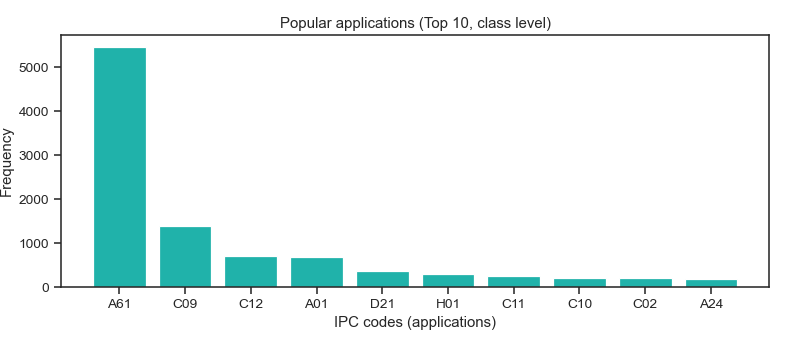

In [440]:
# Draw a bar plot showing the top 10 popular applications
plt.figure(figsize=(9,4))

x_top10_apps = [tup[0] for tup in app_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in app_count_dict_sorted[:10]]

plt.bar(x=x_top10_apps, height=y_counts, color='lightseagreen')

plt.xlabel('IPC codes (applications)')
plt.ylabel('Frequency')
plt.title('Popular applications (Top 10, class level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61: MEDICAL OR VETERINARY SCIENCE, HYGIENE  
C09: DYES; PAINTS, POLISHES, NATURAL RESINS, ADHESIVES  
C12: BIOCHEMISTRY, BEER, SPIRITS, WINE, VINEGAR, MICROBIOLOGY, ENZYMOLOGY, MUTATION OR GENETIC ENGINEERING  
A01: AGRICULTURE, FORESTRY, ANIMAL HUSBANDRY, HUNTING, TRAPPING, FISHING  
D21: PAPER-MAKING, PRODUCTION OF CELLULOSE  
H01: BASIC ELECTRIC ELEMENTS  
C11: ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES, FATTY ACIDS THEREFROM, DETERGENTS, CANDLES  
C10: PETROLEUM, GAS OR COKE INDUSTRIES, TECHNICAL GASES CONTAINING CARBON MONOXIDE, FUELS, LUBRICANTS, PEAT  
C02: TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE  
A24: TOBACCO, CIGARS, CIGARETTES, SIMULATED SMOKING DEVICES, SMOKERS' REQUISITES  

According to the table and plot above, medical use (A61) is the largest group as applications of biodegradable polymers (48% (5,458/11,272)). A61 is a class. In the A61 class, there are many subclasses, and under the subclasses, there are many maingroups, which explain more details. Explore the mainclasses in A61 to determine what are the popular applications in the A61 class.

### 2.5. Popular applications in the medical category (A61)

Check the popular maingroups in A61.

In [35]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
A61_count_dict = {}

# Extract keyes having 'A61' and the values
for k, v in ipc_freq.items():
    if k[:3] == 'A61':
        ipc_maingroup = re.search('A61[A-Z] [0-9]+', k).group()
        if ipc_maingroup in A61_count_dict.keys():
            A61_count_dict[ipc_maingroup] += v
        else:
            A61_count_dict[ipc_maingroup] = v

# Sort by the frequency 
A61_count_dict_sorted = sorted(A61_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of maingroup
print('The number of maingroups:', len(A61_count_dict_sorted))

The number of maingroups: 86


<IPython.core.display.Javascript object>


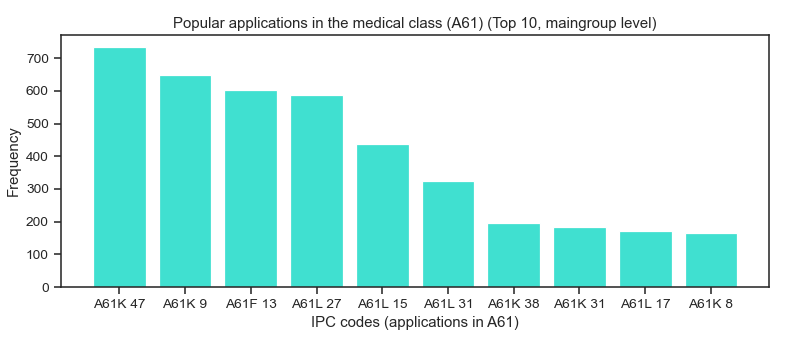

In [441]:
# Draw a bar plot showing the top 10 popular maingroups in A61
plt.figure(figsize=(9,4))

x_top10_apps_A61 = [tup[0] for tup in A61_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in A61_count_dict_sorted[:10]]

plt.bar(x=x_top10_apps_A61, height=y_counts, color='turquoise')

plt.xlabel('IPC codes (applications in A61)')
plt.ylabel('Frequency')
plt.title('Popular applications in the medical class (A61) (Top 10, maingroup level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61K 47: Medicinal preparations (the non-active ingredients used, e.g. carriers or inert additives), targeting or modifying agents (chemically bound to the active ingredient)    
A61K 9: Medicinal preparations (special physical form)   
A61F 13: Bandages, dressings, absorbent pads  
A61L 27: Prostheses, coating prostheses  
A61L 15: Chemical aspects of materials for bandages, dressings or absorbent pads  
A61L 31: Other surgical articles  
A61K 38: Medicinal preparations (containing peptides)  
A61K 31: Medicinal preparations (containing organic active ingredients)  
A61L 17: Surgical sutures, ligaturing blood vessels  
A61K 8: Cosmetics or toilet preparations  

'A61 47', 'A61 9', 'A61L 27', 'A61K 38', 'A61K 31', and 'A61L 17' could be used inside our body. So it makes sense that the material would be required to biodegrade in our body. 'A61F 13', 'A61L 15', 'A61L 31', and 'A61K 8' are used outside of our body. The 'biodegrade' might mean that the material biodegrades by water, bacteria, or enzyme in a natural environment.

### 2.6. Language variety

According to the first 5 rows of the 'df', it includes at least Spanish, Chinese, English, and Japanese. Because I'm going to use abstracts to calculate the similarities between patents, it's important to know what languages are used and the percentage of each. We already know that the 'Abstract' column has missing values. First, take a look at the rows having NaN in the "Abstract" column.

In [37]:
# Extract the patents having NaN in the "Abstract" column
df_abst_nan = df[df['Abstract'].isna()]

print('The number of patents without an abstract:', len(df_abst_nan))
print('df_abst_nan (first 2 rows):')
df_abst_nan.head(2)

The number of patents without an abstract: 578
df_abst_nan (first two rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
46,AU236516509,2018282377,20.12.2018,AU,BIO-BASED POLYETHYLENE TEREPHTHALATE PACKAGING AND METHOD OF MAKING THEREOF,NaN,C08G 63/183; B65D 65/46; C08L 67/03; C08L 101/16; D01F 6/62,The Coca-Cola Company,NaN
74,JP293331120,2018545678,30.07.2018,JP,リグニンの製造方法,NaN,C08H 7/00; C08L 97/00; C08L 101/16,東レ株式会社,荒井 喬広; 栗原 宏征; 舩田 茂行; 山田 勝成


There are 578 patents without an abstract. At least some of them seem to have a title. It will be better to use a title as an abstract than without it. Check how many patents don't have a title nor an abstract.

In [38]:
# Extract the patents having NaN in the "Title" and "Abstract" columns
df_title_abst_nan = df_abst_nan[df_abst_nan['Title'].isna()]

print('The number of patents without a title or an abstract:', len(df_title_abst_nan))

The number of patents without a title or an abstract: 9


In [40]:
# Show the 9 patents 
print('The 9 patents without a title and abstract:')
df_title_abst_nan

The 9 patents without a title and abstract:


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
7967,US38196312,07414964,29.09.1989,US,NaN,NaN,C08G 63/91; C08G 63/84; A61K 47/48; A61K 47/48; C07F 5/00; C07F 5/00; C08G 63/00; C08G 63/08; C0...,DU PONT,STEPHAN J MCLAIN; NEVILLE E DRYSDALE
8052,GR228996259,810164951,14.05.1981,GR,NaN,NaN,A61K 9/58; A61K 9/00; A61K 9/20; A61K 9/22; A61K 9/70; A61K 31/765; A61K 47/34; A61K 47/48; C08G...,SRI INTER NATIONAL,HELLER JORGE; HELWING ROBERT FRANK; PENHALE DONALD WILLIAM HENRY
8070,GR228990772,800162846,09.09.1980,GR,NaN,NaN,C08G 63/00; A61K 9/22; A61K 47/34; C08G 63/06; C08G 63/82; C08L 101/16,ROBERT STEPHEN NEVIN,NEVIN ROBERT STEPHEN
8136,DK191243254,104575,14.03.1975,DK,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 1/17; C07D 253/10; C08L 101/16,CIBA GEIGY AG,DIEL P J
8137,FR187029813,7508014,14.03.1975,FR,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 20/195; C07D 253/10; C08L 101/16,CIBA GEIGY AG,NaN
8141,FR186821567,7503571,05.02.1975,FR,NaN,NaN,C12P 19/12; B29C 45/00; B29C 47/00; B29C 47/78; B29C 59/00; C08J 9/04; C08L 5/00; C08L 101/16,SUMITOMO CHEMICAL CO,NaN
8152,FR187764018,7425620,24.07.1974,FR,NaN,NaN,C08F 16/00; C08F 16/38; C08F 20/44; C08F 220/00; C08F 220/42; C08F 279/02; C08L 101/16,ICI LTD,NaN
8155,FR185556104,7316542,08.05.1973,FR,NaN,NaN,C08G 18/00; C08K 5/00; C08L 1/00; C08L 3/00; C08L 23/00; C08L 27/00; C08L 75/00; C08L 75/06; C08...,COLOROLL LTD,NaN
8162,FR187829230,7203573,03.02.1972,FR,NaN,NaN,B65D 1/00; B65D 25/34; B65D 65/40; C08L 61/06; C08L 97/00; C08L 97/02; C08L 101/16,BIOCOR CORP,NaN


9 patents didn't have the title nor abstract. It's 0.1% (9/8,182). I leave them as is because all of the 9 patents have many IPC codes and the IPC codes can be used to search the relationships with other patents at least.  
  
Fill the abstracts with the titles for patents having a title but not having an abstract.

In [44]:
# Make a new DataFrame to hold the data after filling the abstracts by the titles
df_with_abst = pd.DataFrame(columns=df.columns)

# Fill out the abstract with the title if the patent has a title but not an abstract. 
for i in tqdm(range(len(df))):
    df_with_abst = df_with_abst.append(df.iloc[i])
    if type(df.loc[i, 'Abstract']) == float:
        df_with_abst.loc[i, 'Abstract'] = df_with_abst.loc[i, 'Title']
        
print('df_with_abst (first 5 rows):')
df_with_abst.head()

100%|█████████████████████████████████████| 8182/8182 [00:39<00:00, 206.07it/s]

df_with_abst (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


According to exploring the abstracts, some HTML tags and line feed codes ('\n') are included in abstracts. They can be an obstacle to identify the languages. Remove them before identifying what kind of languages are used.

In [45]:
# Remove HTML tags and line feed codes 
for i in range(len(df_with_abst)):
    if type(df_with_abst.loc[i, 'Abstract']) == str:
        # Remove HTML tags
        text = re.sub(r'<.+?>', '', df_with_abst.loc[i, 'Abstract'])
        
        # Remove '\n' 
        df_with_abst.loc[i, 'Abstract'] = text.replace('\n', '')

print('After removing HTML tags and line feed codes')
print('df_with_abst (first 5 rows):')
df_with_abst.head()

After removing HTML tags and line feed codes
df_with_abst (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


Here, a [language identification model](https://fasttext.cc/docs/en/language-identification.html) by [fastText](https://fasttext.cc/) is used to identify the languages of abstracts. FastText is a library developed by Facebook. The pre-trained model ('lid.176.bin') predicts the language used in a given text. It can recognize 176 languages.  
  
The function `predict_language` predicts the language of a given text. If the result is more than 70% sure, the predicted language is returned, and if it is less than 70%, 'unsure' is returned. Here, I chose 70% as a cut-off point because of the balance between the accuracy and the number of 'unsure.' The accuracy is still very good at 70% (you will see it later.)

In [46]:
# Define a function predicting the language
def predict_language(text):
    '''identify language, and return it if it is more than 70% sure'''
    
    # Lower the text
    text = text.lower()
    
    # Predict language
    label, prob = li_model.predict(text)
    
    # Return the language if more than 70% sure
    if prob > 0.7:
        return label[0].replace("__label__", "")
    else:
        return 'unsure'

In [47]:
# Make a new column to store the predicted languages
df_with_abst['Language'] = ''

# Predict the languages
for i in range(len(df_with_abst)):
    if type(df_with_abst.loc[i, 'Abstract']) == float:
        df_with_abst.loc[i, 'Language'] = 'no abstract'
    else:
        language = predict_language(df_with_abst.loc[i, 'Abstract'])
        df_with_abst.loc[i, 'Language'] = language
            
print('df_with_abst (first 2 rows):')
df_with_abst.head(2)

df_with_abst (first 2 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN,es
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红,zh


Check if the languages were correctly identified. 100 datapoints are randomly selected from the dataframe using the following codes. Then, I check the accuracy by hand.

In [49]:
# Error analysis
# Extract 100 random samples from df_with_abst
df_accuracy_check = df_with_abst.sample(n=100, random_state=1)[['Patent_Id', 'Country', 'Abstract', 'Language']]

In [50]:
# Please change the numbers inside iloc[] to check the accuracy
print('Random samples from df_with_abst:')
df_accuracy_check.iloc[90:]

Random samples from df_with_abst:


,Patent_Id,Country,Abstract,Language
1681,JP273410613,JP,工程（ａ）から（ｃ）を含むポリラクチドフィルムの形成方法。工程（ａ）では、剥離剤コーティングを備える処理されたツール表面が提供される。この処理されたツール表面は、ポリラクチドのガラス転移温...,ja
5340,JP269633797,JP,PROBLEM TO BE SOLVED: To provide a new polymer useful as a polymer surface-active agent or an em...,en
6233,JP268554415,JP,PROBLEM TO BE SOLVED: To obtain a flame-retarded composition excellent in workability on a sheet...,en
4029,WO2005059014,WO,"A biodegradable foam that excels in biodegradability, moldability and heat resistance and that e...",en
2774,JP271756167,JP,PROBLEM TO BE SOLVED: To provide a biomass derived fiber reinforced flame-retardant resin compos...,en
2270,JP272273207,JP,PROBLEM TO BE SOLVED: To provide a method for producing a new and useful biodegradable resin com...,en
3390,JP271278925,JP,PROBLEM TO BE SOLVED: To obtain a resin composition having a low environmental load that excels ...,en
3125,JP272189887,JP,新規な生分解性リン酸エステルポリアミンを開示する。この生分解性リン酸エステルポリアミンは、組織の接着剤または封止剤として使用することができる吹付可能組成物のための架橋剤として利用することができ...,ja
8041,EP11519558,EP,BIORESORBABLE POLYESTERS AND POLYESTER COMPOSITES,unsure
4356,BR6308693,BR,"""PROCESSO DE FABRICAçãO DE MOLDAGEM DE CELULOSE, APARELHO DE EXTRAçãO DE COMPONENTE DE PLANTA E ...",pt


The accuracy was 100% at the 100 random samples. I assume the other datapoints are also accurate. Next, check the number of datapoints having NaN in the abstract and the number of patents in which the language is not sure.

In [51]:
print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 130


The 9 patents were already discussed. They do not have a title nor an abstract. 130 (1.6%) patents had a low prediction rate. Check them and identify the language by hand.

In [52]:
# Extract the patents which language is 'unsure' 
df_unsure_language = df_with_abst[df_with_abst['Language'] == 'unsure'][['Patent_Id', 'Country', 'Abstract', 'Language']]

print('df_unsure_language (first 5 rows):')
df_unsure_language.head()

df_unsure_language (first 5 rows):


,Patent_Id,Country,Abstract,Language
77,WO2019022502,WO,"Provided are: a method for preparing biodegradable polymer microparticles and, particularly, por...",unsure
906,EP254727492,EP,BIODEGRADABLE POLYMERIC NANOCOMPOSITE MATERIALS AND APPLICATIONS OF THE SAME,unsure
987,PT232813269,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
988,PT278275348,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
991,ES105853532,ES,Contenedor biodegradable para inóculos fúngicos,unsure


Each patent has the 'Country' column. It will be connected to the language kind of the patent. For example, when a patent is registered in a country in which an official language is English, the patent would be written in English. First, check the country variety in df_unsure_language.

In [53]:
# Show the unique values in the 'Country' column
print('The unique values in the "Country" column:')
df_unsure_language['Country'].unique()

The unique values in the "Country" column:


array(['WO', 'EP', 'PT', 'ES', 'JP', 'ID', 'US', 'BR', 'EE', 'IT', 'GR',
       'PH', 'AU', 'AR', 'NZ', 'RO', 'DK', 'GB', 'SE'], dtype=object)

Some countries in the list use English as an official language: US (America), PH (Philippines), AU (Australia), 'NZ (New Zealand), and GB (United Kingdom). Also, WO (WIPO, World Intellectual Property Organization) and EP (EPO, European Patent Office) use English for their publications. The patents from the countries and organizations should be written in English. I have decided to label them as 'en'. Then, check the languages of rest of the patents. 

In [54]:
# Make a list of the countries in which English is used as an official language 
english_countries_list = ['WO', 'US', 'PH', 'AU', 'NZ', 'EP', 'GB']

# Countries in which English is not used as the first language 
non_english_countries_set = set(df_unsure_language['Country'].unique()) - set(english_countries_list)

# Check the language by hand
print('Show the abstracts having a country code of non-English country to identify the languages:')
for country in non_english_countries_set:
    print('-------------------------------------------------------------------------')
    print('Country code:', country)
    print(df_unsure_language[df_unsure_language['Country'] == country]['Abstract'])

Show the abstracts having a country code of non-English country to identify the languages:
-------------------------------------------------------------------------
Country code: IT
5255                      COPOLIMERI A BLOCCHI AMORFO-CRISTALLINI
5257    COPOLIESTERI TERMOPLASTICI SATURI/INSATURI BIODEGRADABILI
5258    COPOLIESTERI TERMOPLASTICI SATURI/INSATURI BIODEGRADABILI
7233                    BASTONCINI COTONATI IN MATERIALE PLASTICO
7999                   POLISACCARIDI CARBOSSIILICI AUTORETICOLATI
Name: Abstract, dtype: object
-------------------------------------------------------------------------
Country code: EE
5198    Lipiid-polümeer konjugaadid
Name: Abstract, dtype: object
-------------------------------------------------------------------------
Country code: RO
7757    BIODEGRADABLE POLYMERS
Name: Abstract, dtype: object
-------------------------------------------------------------------------
Country code: SE
8083                                 PLASTBASERAD BLANDNIN

In [56]:
# Identify the language of each country code from the table above
country_language_dict = {'ES':'es', 'IT':'it', 'ID':'id', 'EE':'et', 'BR':'pt', 'DK':'da', 'JP':'ja', 'RO':'en', 'SE':'sv',
                    'PT':'pt', 'AR':'es', 'GR':'en'}

# Make a dictionary for exceptional patents
index_language_dict = {987:'en', 988:'en', 8054:'en', 3738:'en', 4305:'en'}

# Assign the new labels
for i in range(len(df_with_abst)):
    if df_with_abst.loc[i, 'Language'] == 'unsure':
        if df_with_abst.loc[i, 'Country'] in english_countries_list:
            df_with_abst.loc[i, 'Language'] = 'en'
            
        else:    
            df_with_abst.loc[i, 'Language'] = country_language_dict[df_with_abst.loc[i, 'Country']]
            if i in index_language_dict.keys():
                df_with_abst.loc[i, 'Language'] = index_language_dict[i]

print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 0


Now all patents have a language label in the 'Language' column except for the 9 patents. Check the top 5 languages.

In [57]:
# Make a dictionary showing the languages and the frequencies 
language_count_dict = df_with_abst['Language'].value_counts().to_dict()

# Make a DataFrame of top 5 applications
df_language_count = pd.DataFrame(data={'Language code':list(language_count_dict.keys()), 
                                   'Count':list(language_count_dict.values())})
# Show the top 5 languages
print('The number of language kinds:', len(language_count_dict))
print('Top 5 languages:')
df_language_count.head()

The number of language kinds: 19
Top 5 languages:


,Language code,Count
0,en,6687
1,ja,799
2,es,237
3,pt,184
4,ko,59


81.7% (6687/8182) of the abstracts is written in English. The accuracy of the language identification was already checked, but check it again after removing English abstracts so that we can see the rest of them enough.

In [58]:
# Error analysis
# Extract non-English rows
df_with_abst_except_en = df_with_abst[df_with_abst['Language'] != 'en']
df_accuracy_check2 = df_with_abst_except_en.sample(n=100, random_state=1)[['Patent_Id', 'Country', 'Abstract', 'Language']]

In [59]:
# Please change the numbers inside iloc[] to check the accuracy
df_accuracy_check2.iloc[95:100]

,Patent_Id,Country,Abstract,Language
5477,JP269947872,JP,酵素合成アミロースから得られる生分解性物品,ja
3010,ES144955331,ES,"Composición de plástico biodegradable, artículo moldeado a partir de la composición y método par...",es
5374,BR6275281,BR,"""COPOLìMEROS BIODEGRADáVEIS DE POLIHIDROXIALCANOATO COM PROPRIEDADES MELHORADAS DE CRISTALIZAçãO...",pt
1559,JP272882062,JP,【課題】ポリエステルポリオール由来のポリウレタンとしての特性である耐熱、耐候性、耐水性を維持したまま、地球環境に優しく、ポリウレタン反応の制御がし易く、更にポリウレタンの伸度や弾性率の優れたポ...,ja
7762,JP265774282,JP,【構成】 下記の３成分（Ａ）～（Ｃ）を主成分とする プリント基板マスキングテープ用硬化性組成物； （...,ja


The accuracy was 100% at the 100 randam samples again. I assume the other datapoints are also accurate. Draw the plot of the language variety. 

<IPython.core.display.Javascript object>


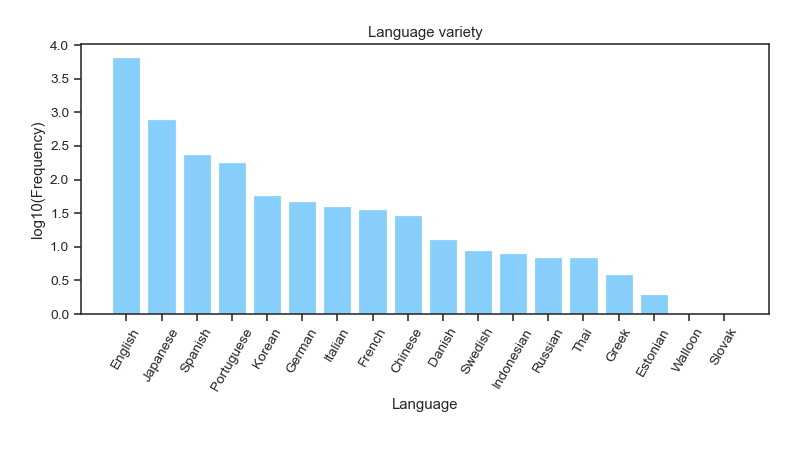

In [60]:
# Remove 'no abstract' from language_count_dict to draw a plot
language_count_dict.pop('no abstract')

# Draw a bar plot of the language variety
plt.figure(figsize=(9,5))

# Exchange the abbriviations into the full names (using iso_language_codes)
x_languages = [language_name(lan) for lan in language_count_dict.keys()]

# Transform the counts into logarithm 
y_counts = [np.log10(val) for val in language_count_dict.values()]

plt.bar(x_languages, y_counts, color='lightskyblue')

plt.xlabel('Language')
plt.ylabel('log10(Frequency)')
plt.title('Language variety')

plt.xticks(rotation=60)

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.90)
plt.show()

81.7% (6,687/8,182) of the abstracts is written in English. 9.8% (799/8,182) is written in Japanese. The abstracts in English and Japanese will be used to calculate the similarity of patents because I can understand the two languages. On the other hand, the IPC codes can be used to analyze the relationships even if a patent is written in other languages. So I'll keep them too. 

## 3. Data Wrangling  

The purpose of this section is to make the data ready for modeling. I deal with the 'Abstract' column to prepare for calculating the similarities between patents.

3.1. Translate Japanese to English  
3.2. Tokenization  
3.3. Clean up tokens   
3.4. Adjust the number of tokens per patent

### 3.1. Translate Japanese to English

9.8% of the abstracts was written in Japanese. Here, translate those abstracts into English to use them to calculate the similarities between patents.

In [84]:
# Extract patents having Japanese abstracts
df_ja_abst = df_with_abst[df_with_abst['Language'] == 'ja']

print('df_ja_abst (first row):')
df_ja_abst.head(1)

df_ja_abst (first row):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja


In [66]:
# Check the abstracts
print('Randomly sampled Japanese abstracts:')
print('See several abstracts to check the formats.')
df_ja_abst['Abstract'].sample(5)

Randomly sampled Japanese abstracts:
See several abstracts to check the formats.


3825      本発明は組成物を水性の媒質へと送達するための容器詰めされた組成物である。この容器詰めされた組成物は、生分解性のデンプン系ポリマーで作製された剛性容器、及び前記容器の内部の無水の組成物を含む...
7874                                                                         滑性及びアンチブロッキング性の改善された熱可塑性樹脂フィルム
709         本発明は、建築又は工業用板材を生分解性樹脂及び木粉を含めて製造することから、優れた物性が得られ、樹脂そのものの生分解性により埋め込み時に環境汚染の虞がないことから、人体及び環境が保護さ...
3861      本発明は、少なくとも１種類の生分解性ブロックコポリエステルウレタン、多糖類および／またはその誘導体を含む少なくとも１種類の充填材を含み、さらに生体適合性添加剤を含むことができる、複合材料系...
3177    種々の態様における本発明は、エラストマー性生分解性ポリマーを提供する。種々の実施態様において、ポリマーは、多官能性アルコール又はエーテルと、二官能性又は高次の酸との反応により、架橋されてエラス...
Name: Abstract, dtype: object

The abstracts have a format. Each abstract has '【課題】'(problem) and '【解決手段】'(means for solving the problems).They are a title of the following sentenses. Also, the expressions after '【選択図】' (figure) mean the explanation about the figure originally included in the database. Remove them.

In [85]:
# Remove titles 
for i in range(len(df_ja_abst)):
    
    # Remove '【選択図\】' plus a following number
    text = re.sub(r'\【選択図\】.*', '', df_ja_abst.loc[df_ja_abst.index[i], 'Abstract'])
    
    # Remove titles
    df_ja_abst.loc[df_ja_abst.index[i], 'Abstract'] = re.sub(r'\【.+?\】', '', text)

print('df_ja_abst (first row)(after removing the titles):')
df_ja_abst.head(1)

df_ja_abst (first row)(after removing the titles):


C:\Users\namik\Anaconda3\envs\springboard2\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\namik\Anaconda3\envs\springboard2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja


In [86]:
# Take a look at the full abstract of the first patent
print('The full abstract of the first patent:')
df_ja_abst.iloc[0, df_ja_abst.columns.get_loc('Abstract')]

The full abstract of the first patent:


'生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであって、該親水性成分が、ポリ（１，５−ジオキセパン−２−オン）、ポリ（１，４−ジオキサン−２−オン）、または、ポリエチレンオキシドの少なくとも１つを含み、該親水性成分のモル比が５％以上８５％以下である、抗血小板粘着性を示す生分解性共重合体。'

They have been removed. Next, translate Japanese to English. Here, I use a translation library called [googletrans](https://py-googletrans.readthedocs.io/en/latest/), which is developed by Google. It is free, but there is a restriction that is a maximum of 15k words in 24 hours from one IP address. I divide df_ja_abst into two part so that each of them has less than 15k words. (If you want to avoid the restriction, there is a [paid version](https://cloud.google.com/translate/docs).) I save df_ja_abst with the translated abstracts as a CSV file. If you need it, go to 4 more cells from here. 

ここから

In [87]:
#  Make a new column to store translated abstracts
df_ja_abst = df_ja_abst.assign(Translated_Abstract = '')

# Copy df_ja_abst
df_ja_abst_copy = df_ja_abst.copy()

# The first half
# Translate Japanese abstracts into English (using googletrans)
for i in tqdm(range(400)):
    # Generate a translator 
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_copy.loc[df_ja_abst_copy.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst.loc[df_ja_abst.index[i], 'Translated_Abstract'] = en_text.text

100%|████████████████████████████████████████| 400/400 [02:16<00:00,  2.92it/s]


In [89]:
# The second half
# Translate Japanese abstracts into English
for i in tqdm(range(400, len(df_ja_abst))):
    # Generate a translator (googletrans)
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_copy.loc[df_ja_abst_copy.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst.loc[df_ja_abst.index[i], 'Translated_Abstract'] = en_text.text
    
print('df_ja_abst (first row):')
df_ja_abst.head(1)  

100%|████████████████████████████████████████| 399/399 [04:27<00:00,  1.49it/s]

df_ja_abst (first row):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language,Translated_Abstract
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provi..."


In [90]:
# Save the dataframe as a csv file
# df_ja_abst.to_csv('df_ja_abst.csv')

In [91]:
# If you need the result (df_ja_abst with the translated abstracts)
# Load the CSV file 
df_ja_abst_file = 'df_ja_abst.csv'
df_ja_abst = pd.read_csv(df_ja_abst_file, index_col=0)

Check if the translation is right. Randomly extract 80 samples (rows) from df_ja_abst, and check the accuracy.

In [92]:
# Error analysis: take a look at 80 samples of the translated sentenses to identify the translation was right 
# Extract 80 random samples
df_accuracy_check3 = df_ja_abst.sample(n=80)[['Patent_Id', 'Abstract', 'Translated_Abstract']]

In [93]:
# Please change the numbers inside iloc[] to check the accuracy (from 0 to 80)
pd.set_option("display.max_colwidth", 1000)
df_accuracy_check3.iloc[75:80]

,Patent_Id,Abstract,Translated_Abstract
1113,JP273986777,ポリオレフィンをポリ乳酸（ＰＬＡ）と共に押出し、その後、一軸延伸または二軸延伸を行うことによって、単層および多層の多孔質ポリオレフィンフィルムを作成する。ＰＬＡは多孔性を創出する細孔形成剤として用いられる。このフィルムにおいては、ＰＬＡの含有量を変えることにより、気体および水蒸気の透過率を調整することが出来る。任意で、選択された層の組成に吸着剤を加えてもよい。多孔質フィルムは包装および消費財用途に有用である。特に、ＰＰとＰＬＡの部分的混和性ブレンドは、その混和性ブレンドのＰＬＡ領域が微細であるため、微細な多孔性を作り出すのに有用である。,"Extruded polyolefin with polylactic acid (PLA), followed by performing uniaxial stretching or biaxial stretching, to create a single-layer and multilayer porous polyolefin film. PLA is used as the pore forming agent to create porosity. In this film, by changing the content of the PLA, it is possible to adjust the permeability of gases and water vapor. Optionally, it may be added adsorbent composition of the selected layer. The porous films are useful in packaging and consumer goods applications. In particular, partially miscible blends of PP and PLA, because PLA region of the miscible blends is fine, it is useful to create a fine porosity."
4660,JP270715885,本発明は、生分解性で、熱可塑性の、相分離したセグメント化多ブロック共重合体に関する。本発明の共重合体は、種々の生物医学上の用途、ならびに製薬上の用途を見出す。本発明に従い、３７℃より低いＴｇを持つ、ソフトプレポリマー（Ａ）のセグメント；および４０〜１００℃の相転移温度Ｔｍを持つ、ハードプレポリマー（Ｂ）のセグメントを含む、生分解性で、相分離した共重合体が提供される。,"The present invention is a biodegradable, thermoplastic relates segmented multiblock copolymer phase separation. The copolymer of the present invention, various biomedical applications, and find pharmaceutical application. In accordance with the present invention, with a less than 37 ° C. Tg, segments of a soft prepolymer (A); having a phase transition temperature Tm of and 40 to 100 ° C., containing a segment of hard prepolymer (B), a biodegradable, phase separated copolymer is provided."
6592,JP268387870,合成樹脂とゴムとの混合組成物,Mixed composition of synthetic resin and rubber
3836,JP271795598,ポリヒドロキシアルカノエートを含有するバイオマスからポリヒドロキシアルカノエートを抽出するための改良されたプロセスであって、前記のポリヒドロキシアルカノエートを含有するバイオマスを、低級鎖のケトン類およびこれらの混合物から選択される溶媒と組み合わせてバイオマス液を形成する工程であって、ここで前記バイオマス液が約２５％未満の水を含むもの；前記バイオマス液を約７０℃〜約１２０℃の範囲の温度で約１０〜約３００分間混合する工程；前記バイオマス液からポリヒドロキシアルカノエートを分離して、ＰＨＡが豊富な液を形成する工程であって、ここで前記分離が低くても約４０℃の温度で行われること；前記のＰＨＡが豊富な液を水と混合して、沈殿したポリヒドロキシアルカノエートと不純な溶媒液とを形成する工程であって、ここで前記水は、前記のＰＨＡが豊富な液と、少なくとも３部の水対１部のポリヒドロキシアルカノエートの比率で混合されること；並びに前記の沈殿したポリヒドロキシアルカノエートを前記の不純な溶媒液から回収する工程を含むプロセス。酸化剤類または穏やかな界面活性剤または穏やかな漂白剤での任意の処理を使用して、色および臭気を向上させる。,"An improved process for extracting polyhydroxyalkanoate from a biomass containing the polyhydroxyalkanoate, the biomass containing the polyhydroxyalkanoate, ketones lower strand and the mixtures thereof and forming a combination with a solvent biomass liquid that, where those containing water in the biomass liquor is less than about 25%; about 10 at a temperature in the range of the biomass liquor to about 70 ° C. ~ about 120 ° C. admixing about 300 minutes; from the biomass liquor to separate the polyhydroxyalkanoate, comprising the steps of PHA to form a rich solution, wherein said that the separation is carried out at a temperature of about 40 ° C. to lower ; and the above PHA-enriched liquor is mixed with water, and forming a precipitated polyhydroxyalkanoate and an impure solvent liquor, wherein the water is said PHA and the rich liquid, at least 3 parts of it are mixed at a ratio of water to 1 part polyhydroxyalkanoate; and a process comprising the step of recovering the prec..."
1765,JP273398644,式（Ｉ）を有する化合物を調製するための方法が提供される、ここでＲ１、Ｒ２、およびＲ３は、独立して水素およびアシル基から選択され、ここでＲ１、Ｒ２、およびＲ３のうちの少なくとも１つは、式（ＩＩ）の分枝長鎖アシル基である、ここでｎは９から２１までであり、ｍは２ｎであり、かつｐは０から４までである、ここでＲ１、Ｒ２、およびＲ３のうちの他のものは、式（ＩＩＩ）の短いアシル基から選択され、ここでｑは０から４までである。,"Process for preparing a compound having the formula (I) are provided wherein R1, R2, and R3 are independently selected from hydrogen and acyl groups, of where R1, R2, and R3 at least one is a branched long chain acyl groups of the formula (II), wherein n is from 9 to 21, m is 2n, where and p is from 0 to 4, wherein R1, R2 , and the other of the R3, are selected from a short acyl group of formula (III), where q is from 0 to 4."


Sometimes the translations were not straightforward, but the meanings were mostly fine.

### 3.2. Tokenization 

In this section, I separate the sentences into words to use them for a sentence similarity calculation. First, extract English patents, and take care of the format.  

In [94]:
# Create a new DataFrame to store patents having an English abstract
df_en_abst = pd.DataFrame(columns=['Patent_Id', 'Title', 'Abstract'])

# Extract rows having an English abstract
for i in tqdm(range(len(df_with_abst))):
    if df_with_abst.loc[df_with_abst.index[i], 'Language'] == 'en':
        # Extract rows having an English anstract
        df_en_abst = df_en_abst.append(df_with_abst.loc[df_with_abst.index[i], ['Patent_Id', 'Title', 'Abstract']])
        
print('The number of patents with an English abstract:', len(df_en_abst))

100%|█████████████████████████████████████| 8182/8182 [00:15<00:00, 517.08it/s]

The number of patents with an English abstract: 6687


In [95]:
# Check the abstracts by sampling the data
print('Some samples from df_en_abst:')
df_en_abst.sample(5)

Some samples from df_en_abst:


,Patent_Id,Title,Abstract
6433,JP268440093,PACKAGING MATERIAL FOR ETHANOL TRANSPIRATION AGENT,"PROBLEM TO BE SOLVED: To obtain the subject packaging film useful as an agent for freshness retention, etc., not emitting a harmful exhaust gas even in incineration after use by using a biodegradable resin film. SOLUTION: This packaging material comprises a biodegradable resin film (preferably a film comprising an aliphatic polyester as a constituent component). Preferably the packaging material has at least 20g/m2/24 hr/50% RH/40C ethanol permeability. The packaging material may be a monolayer or a laminate obtained by laminating biodegradable films of the same kind or different kinds or laminating the biodegradable resin film to another air-permeable resin film or a nonwoven fabric. Further the biodegradable resin film can be laminated to a paper to give a laminate. Consequently the objective packaging material having ethanol permeability enough to be an agent for freshness retention of food, readily degradable in soil can be provided.COPYRIGHT: (C)2000,JPO"
2706,JP271854683,RESIN COMPOSITION AND INJECTION-MOLDED PRODUCT,"PROBLEM TO BE SOLVED: To provide a resin composition having excellent flame retardancy.SOLUTION: The composition is prepared by adding 1 pts.mass and 20 pts.mass of (C) phosphonitrilic acid phenyl ester and 1 pts.mass and 50 pts.mass of (D) expandable graphite to 100 pts.mass of a mixture containing 50 mass% and COPYRIGHT: (C)2009,JPO&INPIT"
181,CN212138577,Biodegradablee poly-methyl aethylenum carbonate ester group micro-layer coextrusion composite material and preparation method thereof,"The invention belongs to the technical field of polymer processing, and discloses a biodegradable poly-methyl aethylenum carbonate ester group micro-layer coextrusion composite material and a preparation method thereof. According to the preparation method, poly-methyl aethylenum carbonate ester and a biodegradable modifier are melted, and then the composite material is obtained through micro-layercoextrusion. According to the biodegradable poly-methyl aethylenum carbonate ester group micro-layer coextrusion composite material, two biodegradable polymeric materials are adopted, one of the biodegradable polymeric materials is poly-methyl aethylenum carbonate ester, the other is a biodegradable modifier or a PPC/biodegradable modifier blend, the two biodegradable polymeric materials are supplied by two extruders correspondingly, after the biodegradable polymeric materials pass through an alternating overlapping coextrusion machine head, the composite material is prepared and obtained,..."
5113,JP269795647,BIODEGRADABLE BLOWN FILM AND ITS MANUFACTURING METHOD,"PROBLEM TO BE SOLVED: To provide a film of high strength by investigating a specific raw material resin and its molding condition.SOLUTION: This biodegradable blown film has a breaking strength of not less than 45 MPa in both length and width directions, and the ratio of the both breaking strength is not higher than 1.5, and it is prepared by blown film molding of an aliphatic polyester copolymer which has a glass transition temperature of not higher than 0C, a difference (Tm-Tc) of the melting point, Tm, measured by a differential scanning calorimeter with the temperature raising at a constant rate, and the crystallization temperature, Tc, which is measured by a differential scanning calorimeter with the temperature lowering at a constant rate from melt condition of not larger than 50C, and a melt flow rate measured at the test temperature of 190C and the test load of 2.16 kg, which is based on JIS K 7210 of not higher than 8 g/10 minutes.COPYRIGHT: (C)2004,JPO"
7487,EP13437169,Multilayer materials,"The invention is directed to a composite material, especially a biomedical device, e.g. an ophthalmic device, preferably a contact lens, with one or more wettable surfaces capable of holding a continous layer of aqueous fluid thereon which composite material comprises a bulk mater

Some abstracts have a format. Some patens published in Russia have 'FIELD:', 'SUBSTANCE:', and 'EFFECT:.' Some patents published in Japan have 'PROBLEM TO BE SOLVED:' and 'SOLUTION:'. They are the title of the following sentences. Also, the expressions after 'SELECTED DRAWING:' mean the explanation about the figure originally included in the database, and the expressions after 'COPYRIGHT:' are about copyright. Some patents have 'PURPOSE:' and ' CONSTITUTION:'. They are not needed. Remove them.

In [96]:
# Remove titles 
for i in range(len(df_en_abst)):
    
    # Remove 'SELECTED DRAWING:' plus the following words
    text = re.sub(r'SELECTED DRAWING:.*', '', df_en_abst.loc[df_en_abst.index[i], 'Abstract'])
    
    # Remove 'COPYRIGHT:' plus the following words
    text = re.sub(r'COPYRIGHT:.*', '', text)
    
    # Remove titles
    text = re.sub(r'FIELD:', '', text)
    text = re.sub(r'SUBSTANCE:', '', text)
    text = re.sub(r'EFFECT:', '', text)
    text = re.sub(r'PROBLEM TO BE SOLVED:', '', text)
    df_en_abst.loc[df_en_abst.index[i], 'Abstract'] = re.sub(r'SOLUTION:', '', text)

print('df_en_abst (first two rows) (after removing the titles):')
df_en_abst.head(2)

df_en_abst (first two rows) (after removing the titles):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
5,WO2020059793,RESIN MOLDED ARTICLE AND METHOD FOR PRODUCING SAME,"A resin molded article and a method for producing the same, the resin molded article having an interlayer molding obtained by molding a resin including a thermoplastic water-soluble polymer, and at least one shielding layer for shielding the entire outer periphery of the interlayer molding from the external environment, the occurrence of microplastic from the resin molded article being suppressed, the persistence of microplastic discharged into the ocean, etc., from the resin molded article being reduced, and there being no risk of adverse effects on the natural environment from the resin molded article."


Next, concatenate df_en_abst and df_ja_abst to prepare for tokenization.

In [97]:
# Extract the 'Patent_Id' and 'Translated_Abstract' columns from df_ja_abst
df_ja_abst_extracted = df_ja_abst[['Patent_Id', 'Title', 'Translated_Abstract']]

# Rename the column
df_ja_abst_extracted = df_ja_abst_extracted.rename(columns={'Translated_Abstract': 'Abstract'})

# Merge df_en_abst and df_ja_abst_extracted
df_enja_abst = df_en_abst.append(df_ja_abst_extracted).sort_index()

print('The number of rows of df_enja_abst:', len(df_enja_abst))
print('df_enja_abst (first five rows):')
df_enja_abst.head()

The number of rows of df_enja_abst: 7486
df_enja_abst (first five rows):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provide a biodegradable copolymer to exhibit anti-platelet adhesion of the novel structure unprecedented. An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component, the hydrophilic component is poly (1,5-dioxepan-2-one), poly (1,4-dioxan-2 on), or comprises at least one of polyethylene oxide, the molar ratio of the hydrophilic component is 85% or less than 5%, the raw shows the anti-platelet adhesion degradable copolymer."
5,WO2020059793,RESIN MOLDED ARTICLE AND METHOD FOR PRODUCING SAME,"A resin molded article and a method for producing the same, the resin molded article having an interlayer molding obtained by molding a resin including a thermoplastic water-soluble polymer, and at least one shielding layer for shielding the entire outer periphery of the interlayer molding from the external environment, the occurrence of microplastic from the resin molded article being suppressed, the persistence of microplastic discharged into the ocean, etc., from the resin molded article being reduced, and there being no risk of adverse effects on the natural environment from the resin molded article."
6,JP290898185,生分解性ゴム組成物、生分解性ゴム組成物の製造方法及び生分解性ゴム成形品,"To contribute to environmental protection, with the biodegradability, mechanical properties, excellent good self-adhesive and the like balanced, providing a flexible, characteristic variation is suppressed polymeric material. The present invention, a natural rubber and an inorganic material powder 45: 55-10: contain a weight ratio of 90, and a modified cellulose to said natural rubber 100 parts by weight containing 0.5 to 10.0 parts by weight comprising providing a biodegradable rubber composition."
7,WO2020066679,RESIN COMPOSITION AND MOLDED BODY THEREOF,"Provided is a resin composition containing: a polylactic acid; and a copolyester of a lactic acid and another hydroxycarboxylic acid. The other hydroxycarboxylic acid may be 3-hydroxybutanoic acid, 3-hydroxypentanoic acid, 3-hydroxyhexanoic acid, 3-hydroxyheptanoic acid, 3-hydroxyoctanoic acid, 3-hydroxynonanoic acid, 3-hydroxydecanoic acid, 3-hydroxydodecanoic acid, 3-hydroxytetradecanoic acid, 3-hydroxypentadecanoic acid, or 3-hydroxyhexadecanoic acid."


Compound names generally have numbers and punctuations (e.g. poly (1,5-dioxepan-2-one)). Because I would like to remain the sets of numbers and structure names, remove the punctuations before the tokenization. 

In [98]:
# Remove punctuations (using 'string' library)
df_enja_abst_noPunc = df_enja_abst.copy()

for i in tqdm(range(len(df_enja_abst_noPunc))):
    
    abst = df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract']
    # Remove punctuations
    df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract'] = abst.translate(str.maketrans('', '', string.punctuation))

print('df_enja_abst (first 2 rows):')
df_enja_abst_noPunc.head(2)

100%|████████████████████████████████████| 7486/7486 [00:01<00:00, 6053.16it/s]

df_enja_abst (first 2 rows):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,It combines the biodegradability and antithrombotic also excellent in shape stability to provide a biodegradable copolymer to exhibit antiplatelet adhesion of the novel structure unprecedented An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component the hydrophilic component is poly 15dioxepan2one poly 14dioxan2 on or comprises at least one of polyethylene oxide the molar ratio of the hydrophilic component is 85 or less than 5 the raw shows the antiplatelet adhesion degradable copolymer


See the second row. 'Poly (1,5-dioxepan-2-one)' became 'poly 15dioxepan2one.' If tokenization were implemented without removing punctuations, the compound name would be tokenized into 'poly', '1', '5', 'dioxepan', '2', 'one'. The features are divided into many tokens and it is difficult for the prediction model to identify the tokens as the compound name unless using hexagrams. By removing punctuations before tokenization, the compound is recognizable as bigrams.

Now, 91.5% (7,486/8,182) of the patents in the data have an English abstract. They will be used to calculate the similarities between patents. Next, tokenize the abstracts in df_enja_abst_noPunc.

In [99]:
# Make a list from df_enja_abst_noPunc['Abstract']
abst_list = list(df_enja_abst_noPunc['Abstract'])

# Tokenize the abstracts
tokens_list = [nltk.word_tokenize(abst) for abst in abst_list] 

# How many unique words?
before_word_number = len(set(token for abst in tokens_list for token in abst))

print('Number of unique tokens:', before_word_number)
print("tokens_list (several tokens of the second patent):")
tokens_list[1][25:45]

Number of unique tokens: 22500
tokens_list (several tokens of the second patent):


['An',
 'aliphatic',
 'Poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

### 3.3. Clean up tokens

In this section, tokens that are not useful to calculate the similarities are removed, and tokens are standardized to the base forms. 

3.3.1. Lower the case  
3.3.2. Remove stop words   
3.3.3. Remove numbers  
3.3.4. Stemming  
3.3.5. Frequent words

#### 3.3.1. Lower the case

First, lower the case.

In [100]:
# Lower the case
tokens_lower_list = [[token.lower() for token in abst] for abst in tokens_list]

print("tokens_lower_list (several tokens of the second patent):")
tokens_lower_list[1][25:45]

tokens_lower_list (several tokens of the second patent):


['an',
 'aliphatic',
 'poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

#### 3.3.2. Remove stop words

Also, stop words have less information about a patent. Remove stop words.

In [101]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_noStop_list = [[token for token in abst if token not in cached_stop_words] 
                      for abst in tokens_lower_list]

print("tokens_nostop_list (several tokens of the second patent):")
tokens_noStop_list[1][25:45]

tokens_nostop_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 '85',
 'less',
 '5',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion']

#### 3.3.3. Remove numbers

Numbers can be included frequently. In this project, I decided to remove them to reduce complexity. However, compound names are combinations of numbers and alphabets. Here, let's remove tokens having only numbers.

In [102]:
# Remove numbers
tokens_noNum_list = [[token for token in abst if not token.isnumeric()] for abst in tokens_noStop_list]

print("tokens_noNum_list (several tokens of the second patent):")
tokens_noNum_list[1][25:45]

tokens_noNum_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 'less',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion',
 'degradable',
 'copolymer']

#### 3.3.4. Stemming

English words change the form depending on the context. To reduce inflected words to their word stem (or root) form, stemming are used.

In [103]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')
tokens_stem_list = [[snowball.stem(token) for token in abst] for abst in tokens_noNum_list]

print("tokens_stem_list (first 12 tokens of the first patent):")
tokens_stem_list[1][25:45]

tokens_stem_list (first 12 tokens of the first patent):


['poli',
 '15dioxepan2on',
 'poli',
 '14dioxan2',
 'compris',
 'least',
 'one',
 'polyethylen',
 'oxid',
 'molar',
 'ratio',
 'hydrophil',
 'compon',
 'less',
 'raw',
 'show',
 'antiplatelet',
 'adhes',
 'degrad',
 'copolym']

In [104]:
# How many unique words?
stem_word_number = len(set(token for abst in tokens_stem_list for token in abst))

print('Number of tokens removed:', before_word_number - stem_word_number)
print('Current number of unique tokens:', stem_word_number)

Number of tokens removed: 8013
Current number of unique tokens: 14487


#### 3.3.5. Frequent words

Show the frequent words.

In [105]:
# Count the number of each word 
words_list_after = [token for abst in tokens_stem_list for token in abst]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


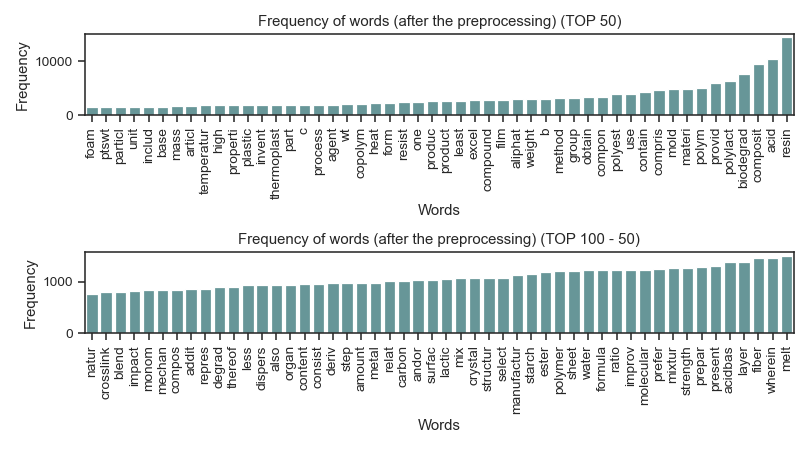

In [106]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Most of the words look useful to characterize patents.

### 3.4. Adjust the number of tokens per patent

Some patents would have many tokens, and some might have a few. If a patent has only some tokens, it could be difficult to be compared with others. I decided to remove patents having less than 5 tokens from df_enja_abst_noPunc. 

In [107]:
# Extract the indexes of the patents having less than 5 tokens
fewToken_index_list = []
for i in range(len(tokens_stem_list)):
    if len(tokens_stem_list[i]) < 5:
        fewToken_index_list.append(i)

print('The number of patents having less than 5 tokens:', len(fewToken_index_list))

The number of patents having less than 5 tokens: 131


In [108]:
# Make a new column, 'Tokens', and assign the token list
df_enja_abst_noPunc['Tokens'] = tokens_stem_list

# Removes rows having less than 5 tokens
df_enja_abst_more5 = df_enja_abst_noPunc.drop(df_enja_abst_noPunc.index[fewToken_index_list])

print('The number of rows of df_enja_abst_more5', len(df_enja_abst_more5))
print('df_enja_abst_more5 (first two rows):')
df_enja_abst_more5.head(2)

The number of rows of df_enja_abst_more5 7355
df_enja_abst_more5 (first two rows):


,Patent_Id,Title,Abstract,Tokens
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole,"[singleus, biodegrad, paper, urin, collector, method, use, urin, collector, includ, funnel, bodi, slope, continu, sidewal, slope, base, top, open, funnel, hole, locat, lowest, region, slope, base, option, urin, sampl, contain, oper, coupl, slope, base, convey, funnel, urin, contain, top, edg, contain, posit, within, funnel, hole, base, contain, posit, outsid, funnel, bodi, funnel, bodi, configur, funnel, stream, urin, top, open, along, interior, surfac, funnel, bodi, toward, funnel, hole]"
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,It combines the biodegradability and antithrombotic also excellent in shape stability to provide a biodegradable copolymer to exhibit antiplatelet adhesion of the novel structure unprecedented An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component the hydrophilic component is poly 15dioxepan2one poly 14dioxan2 on or comprises at least one of polyethylene oxide the molar ratio of the hydrophilic component is 85 or less than 5 the raw shows the antiplatelet adhesion degradable copolymer,"[combin, biodegrad, antithrombot, also, excel, shape, stabil, provid, biodegrad, copolym, exhibit, antiplatelet, adhes, novel, structur, unpreced, aliphat, poriesueru, copolym, hydrophob, compon, hydrophil, compon, hydrophil, compon, poli, 15dioxepan2on, poli, 14dioxan2, compris, least, one, polyethylen, oxid, molar, ratio, hydrophil, compon, less, raw, show, antiplatelet, adhes, degrad, copolym]"


In [109]:
# Make a new token list from df_enja_abst_more5
token_list_np = np.array(df_enja_abst_more5['Tokens'])

print('New token list "token_list_np" (first 5 tokens of the first patent):')
token_list_np[0][:5]

New token list "token_list_np" (first 5 tokens of the first patent):


['singleus', 'biodegrad', 'paper', 'urin', 'collector']

This list is used for the sentence similarity calculation.  
  
Next, check the distribution of the number of tokens per patent.

<IPython.core.display.Javascript object>


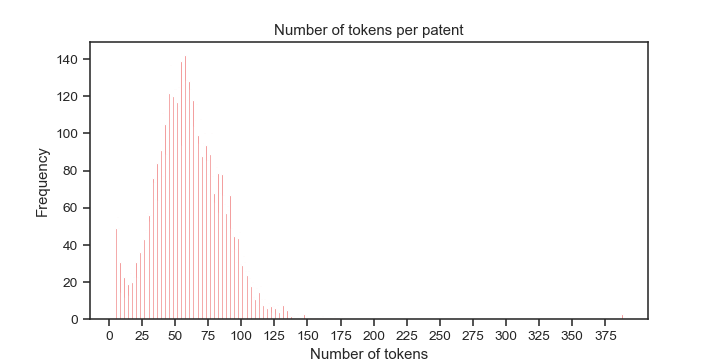

In [110]:
# Count the number of tokens per product
number_token_list = [len(tokens) for tokens in token_list_np]

# Draw a bar plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=max(number_token_list)-min(number_token_list), color='lightcoral') 
plt.xticks(range(0, max(number_token_list), 25))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens per patent') 

plt.show()

In [111]:
# Show the summary statistics as a DataFrame
print('The summary statistics of the number of tokens per patent:')
pd.DataFrame(pd.Series(number_token_list).describe(percentiles=[0.25, 0.75, 0.9])).transpose()

The summary statistics of the number of tokens per patent:


,count,mean,std,min,25%,50%,75%,90%,max
0,7355.0,60.347111,26.569741,5.0,43.0,59.0,77.0,93.0,388.0


The minimum number of tokens per patent became 5. The patents using the titles as the abstracts would have relatively fewer tokens. This might affect the calculation of the similarities between patents. 

## 4. Modeling

The recommendation system has two main features, using a sentence similarity and a network, to recommend applications. When a patent is given by a user, the neighbor patents (that share IPC codes with the given patent) are extracted. The neighbor patents are sorted by the similarities of the abstracts. Then, the application IPC codes are extracted from the top patents. First, calculate the sentence similarities between patents in df_enja_abst_more5. Second, build the network. Finally, create the recommendation system.

4.1. Sentence similarity  
4.2. Build a network  
4.3. Create a recommendation system

### 4.1. Sentence similarity

Tf-idf vectorizer is chosen to transform the token list into a vector so that the importance of each word is standardized. A unigram, bigram, and trigram are used because compound names are often composed of several words. For example, methyl methacrylate, poly (1,5-dioxepan-2-one), or poly (ethylene -co- acrylic acid). They should be considered in the calculation. To reduce the complexity, the tokens appearing less than 3 patents are ignored.   

In [112]:
# Vectorization
def dummy_tokened(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=dummy_tokened, lowercase=False, ngram_range=(1, 3), min_df=3)
vecs = vectorizer.fit_transform(token_list_np)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Show the shape of the matrix
print('Tf-idf matrix: vecs')
print('Matrix shape:', vecs.shape)

Tf-idf matrix: vecs
Matrix shape: (7355, 45438)


Use cosine similarity to calculate the sentence similarities. Cosine similarity is often used to measure the similarities between texts.

In [113]:
# Calculate the cosine similarities
cs_array = np.round(cosine_similarity(vecs.toarray(), vecs.toarray()),3)

# Store the similarities in a new DataFrame
df_similarities = pd.DataFrame(cs_array, 
                               index=df_enja_abst_more5['Patent_Id'], 
                               columns=df_enja_abst_more5['Patent_Id'])

print('df_similarities (first 5 rows):')
df_similarities.head()

df_similarities (first 5 rows):


Patent_Id,US293704217,JP293331568,WO2020059793,JP290898185,WO2020066679,WO2020084945,JP290898180,JP293031281,RU291513243,RU282814286,...,CA284258825,CA94508293,CA94882924,CA124239679,CA160355655,CA94262256,CA93908381,CA224370974,CA93894881,CA189885070
Patent_Id,,,,,,,,,,,,,,,,,,,,,
US293704217,1.000,0.002,0.003,0.013,0.006,0.035,0.016,0.002,0.006,0.019,...,0.004,0.034,0.008,0.003,0.002,0.008,0.000,0.027,0.026,0.039
JP293331568,0.002,1.000,0.006,0.021,0.001,0.031,0.017,0.042,0.018,0.034,...,0.006,0.010,0.036,0.015,0.002,0.036,0.018,0.015,0.016,0.045
WO2020059793,0.003,0.006,1.000,0.015,0.006,0.224,0.026,0.001,0.020,0.017,...,0.003,0.009,0.024,0.018,0.002,0.024,0.006,0.005,0.002,0.013
JP290898185,0.013,0.021,0.015,1.000,0.007,0.038,0.020,0.014,0.066,0.030,...,0.005,0.033,0.084,0.022,0.021,0.084,0.018,0.015,0.043,0.011
WO2020066679,0.006,0.001,0.006,0.007,1.000,0.021,0.012,0.002,0.003,0.008,...,0.003,0.006,0.002,0.004,0.005,0.002,0.004,0.001,0.033,0.013


To evaluate the accuracy, the number of common IPC codes is counted. IPC codes are not exhaustively assigned, but the tendency will be shown.

In [114]:
# Evaluate the accuracy
# Get patent IDs having an English or Japanese abstract
enja_patents_list = list(df_enja_abst_more5['Patent_Id'])
# Make a list to store the number of the common IPC codes to each one of enja_patents_list 
num_commonIpc_list = []

# Sort patent IDs by the similarities to each patent, and count the number of common IPC codes
for patent in tqdm(enja_patents_list):
    # IPC codes of a current target patent
    target_ipcs = patent_ipc_dict[patent]
    # Get the patent IDs in the descending order
    similar_patents = df_similarities.loc[patent].sort_values(ascending=False).index
    
    # Make a list to store the number of the common IPC codes
    n_common_ipcs = []
    
    # Extract similar_patents' IPC codes, and count the number of common IPC codes
    for sim_patent in similar_patents:
        # Get the IPC codes of the similar patent
        similar_patent_ipcs = patent_ipc_dict[sim_patent]
        # Count the number of common IPC codes
        n_common_ipc = len(set(target_ipcs) & set(similar_patent_ipcs))
        # Add the number in n_common_ipcs
        n_common_ipcs.append(n_common_ipc)
    
    # Add the list in num_commonIpc_list
    num_commonIpc_list.append(n_common_ipcs)    

# Transform the list to numpy array for later
num_commonIpc_array = np.array(num_commonIpc_list)

# Calculate the means of common IPC codes
mean_num_commonIpc = np.mean(num_commonIpc_array, axis=0)
# Calculate the mean of the means
mean_mean_num_commonIpc = np.mean(mean_num_commonIpc)

100%|██████████████████████████████████████| 7355/7355 [01:16<00:00, 95.58it/s]


<IPython.core.display.Javascript object>


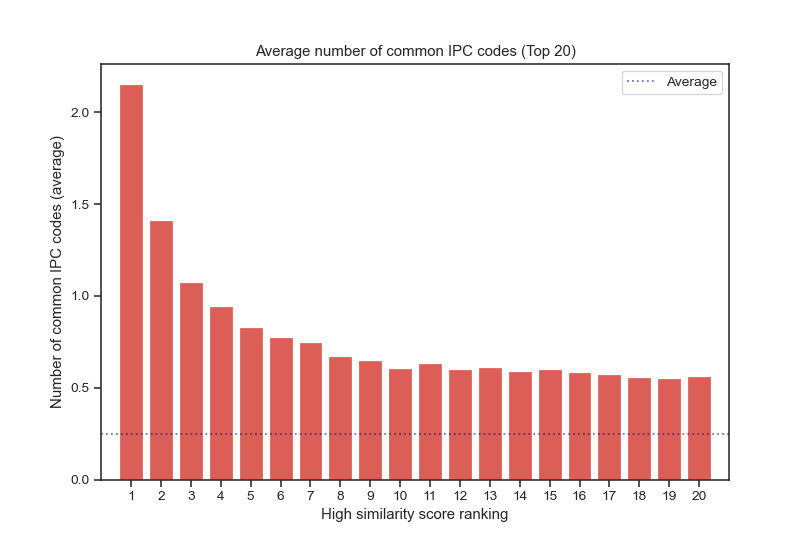

In [115]:
# Create a bar plot
plt.figure(figsize=(9,6))

# Plot from the second to 21st (because the first one is the number of IPC codee of itselt)
plt.bar(range(1, len(mean_num_commonIpc[1:21])+1), mean_num_commonIpc[1:21]) # c='lightcoral'
plt.xlabel('High similarity score ranking')
plt.ylabel('Number of common IPC codes (average)')
plt.xlim([0,21])
plt.xticks(np.arange(1, 21, 1))
plt.axhline(xmin=0, xmax=21, y=mean_mean_num_commonIpc, c='navy', alpha=0.5, ls=':', label='Average')

plt.legend()
plt.title('Average number of common IPC codes (Top 20)')

plt.show()

The higher similarity scores, the more common IPC codes. The similarity calculation works well. Use the similarity scores for the recommendation system.

### 4.2. Build a network

Here, the second feature of the recommendation system, a network, is built. Using a network analysis allows the recommendation system to easily extract neighbor nodes (in this case, neighbor nodes are patents or IPC codes.) 

4.2.1. Create a graph (network)  
4.2.2. Create a patent projection graph

#### 4.2.1. Create a graph (network)

The network is composed of nodes and edges. There are 2 kinds of nodes: patent nodes and IPC code nodes. A patent node is always connected to IPC code nodes by edges if the patent has the IPC codes. There are 8,182 patents and 4,344 IPC codes in the data. The number of nodes will be 12,526 in total.

In [117]:
# Instantiate a new Graph
G = nx.Graph()

# Add patent nodes
G.add_nodes_from(df['Patent_Id'], bipartite='patent', application=False)

# Add IPC code nodes
for ipc in ipc_freq.keys():
    if ipc[:3] in app_count_dict.keys():
        G.add_node(ipc, bipartite='ipc', application=True)
    else:
        G.add_node(ipc, bipartite='ipc', application=False)
        
# Add edged 
for patent, ipcs in patent_ipc_dict.items():
    for ipc in ipcs:
        if ipc in ipc_freq.keys():
            G.add_edge(patent, ipc)
            
print('Patent-IPC graph: G')

Patent-IPC graph: G


In [118]:
# The number of nodes and edges
print('The number of nodes:', len(G.nodes()))
print('The number of edges:', len(G.edges()))

The number of nodes: 12526
The number of edges: 46012


(I will add Unit Test here: len(G.nodes()) == len(df) + len(ipc_freq.keys()))

Check how many kinds of applications. Remember some IPC classes were chosen as applications, app_count_dict.

In [119]:
# Count the number of application nodes
n_app = list(nx.get_node_attributes(G, 'application').values()).count(True)

print('Application kinds:', n_app)

Application kinds: 2153


There are 2,153 kinds of applications in the data. The recommended applications will be chosen among them. 

Before making the recommendation system, explore the network. As an example, I extract the network around 'JP271085664'. 

In [120]:
# Extract the neighbors (IPC codes which 'JP271085664' has )
ex_patent = 'JP271085664'
nei_JP271085664_set = set(G.neighbors(ex_patent))

print('The neighbors of "JP271085664" (IPC codes "JP271085664" has ):')
nei_JP271085664_set

The neighbors of "JP271085664" (IPC codes "JP271085664" has ):


{'A61L 31/00', 'C08K 5/521', 'C08L 101/00', 'C08L 67/00'}

In [121]:
# Make a set to store the neighbors of the neighbors
nei_patents_set = set()

# Extract the neighbors of the neighbors
for ipc in nei_JP271085664_set:
    nei_patents_set = nei_patents_set.union(set(G.neighbors(ipc)))

# The number of the nodes
print('The number of patents sharing the same IPC codes with "JP271085664":', len(nei_patents_set))

The number of patents sharing the same IPC codes with "JP271085664" 2313


The patent, 'JP271085664', has 4 IPC codes, and the 4 IPC codes are connected to 2,313 patents in total. Here, I would like to visualize the network. Because it's very big. I pick up one IPC code, 'A61L 31/00', and visualize the network having nodes of 'JP271085664', the 4 IPC codes, and the neighbor patents of 'A61L 31/00'.

In [122]:
# Extract the neighbor patents of 'A61L 31/00'
nei_A61L3100_set = set(G.neighbors('A61L 31/00'))

# Combine the patent nodes and IPC code nodes
neighbors_set = nei_JP271085664_set.union(nei_A61L3100_set)

# Make a subgraph of the neighbors
G_JP271085664 = G.subgraph(neighbors_set)
print('The subgraph around "JP271085664": G_JP271085664')

# Show the number of the nodes
print('The number of the nodes of G_JP271085664:', len(list(G_JP271085664.nodes())))

The subgraph around "JP271085664": G_JP271085664
The number of the nodes of G_JP271085664: 101


Plot the network.

<IPython.core.display.Javascript object>


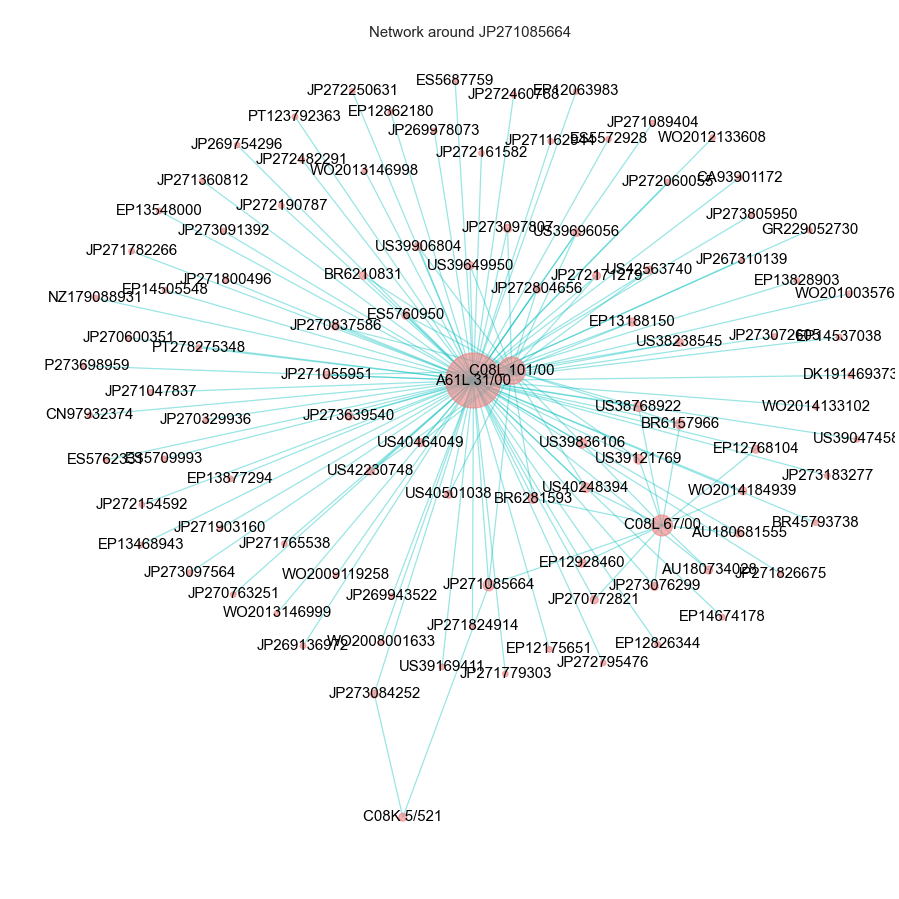

In [123]:
# Make a list to store the node sizes
node_size_list = []

# Count the number of edges of each nodes, and multiple 20 for the node size
for node in list(G_JP271085664.nodes()):
    n_edges = len(list(G_JP271085664.neighbors(node)))
    # To easily see the differences
    node_size_list.append(n_edges*20)

# Plot the network of G_JP271085664
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G_JP271085664, k=0.1)
nx.draw_networkx_nodes(G_JP271085664, pos, node_color="lightcoral",alpha=0.6, node_size=node_size_list)
nx.draw_networkx_labels(G_JP271085664, pos, fontsize=1)
nx.draw_networkx_edges(G_JP271085664, pos, alpha=0.4, edge_color='c')

plt.axis('off')
plt.subplots_adjust(left=0.05, right=0.995, bottom=0.05, top=0.95)
plt.title('Network around JP271085664')
plt.show()

'JP271085664' is connected to the 4 IPC codes, 'A61L 31/00', 'C08K 5/521', 'C08L 101/00', 'C08L 67/00'. Then, 'A61L 31/00' has a connection with 97 patents. According to the network plot, 'C08L 101/00' and 'C08L 67/00' have some connections with the patents 'A61L 31/00' is connected to.  
  
This network is a part of the original graph. The whole graph is more highly connected.

#### 4.2.2. Create a patent projection graph

The graph G has 2 kinds of nodes (patent nodes and IPC code nodes.) Here, I make a new graph having only patent nodes. The new graph is made by projecting the relationships between patent nodes and IPC code nodes. For example, if a patent (P1) has some IPC codes (IPC1 and IPC2) and another patent (P2) has some IPC codes (IPC1, IPC3), it is said that P1 and P2 are indirectly connected through IPC1. In this case, the new graph will have an edge between P1 and P2.  
  
Create a patent projection graph.

In [124]:
# Get the patent nodes
patent_nodes = [node for node, metadata in G.nodes(data=True) if metadata['bipartite'] == 'patent']

# Create the patent node projection 
G_patents = nx.bipartite.projected_graph(G, nodes=patent_nodes)

print('Patent projection graph: G_patents')

# The number of nodes and edges
print('The number of nodes:', len(G_patents.nodes()))
print('The number of edges:', len(G_patents.edges()))

Patent projection graph: G_patents
The number of nodes: 8182
The number of edges: 7035567


Degree centrality is a rate of the number of edges to the potential number of edges. If it is 1, the node is connected to all the other nodes, and if it is 0.5, the node is connected to the half of the other nodes.  
  
Visualize the degree centrality distribution of the patent projection. 

<IPython.core.display.Javascript object>


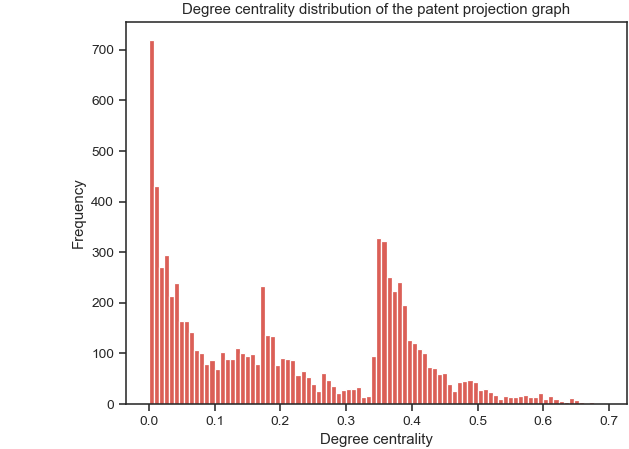

In [125]:
# Calculate the degree centrality 
degree_centrality_patent = nx.degree_centrality(G_patents)

# Plot the histogram of degree centrality values
plt.figure(figsize=(7,5))
plt.hist(list(degree_centrality_patent.values()), bins=int(np.sqrt(len(G_patents.nodes()))))

plt.xlabel('Degree centrality')
plt.ylabel('Frequency')

plt.title('Degree centrality distribution of the patent projection graph') 

plt.subplots_adjust(left=0.2, right=0.995, bottom=0.1, top=0.95)
plt.show() 

There are 3 peaks around 0, 0.18, and 0.36. Because the graph has 8,182 nodes, 0.18 means more than 1470 connections and it is a lot. That is why the sentence similarity is used to prioritize them. On the other hand, if a degree centrality is very close to 0, the patent has only a few edges (connections with the other patents). Then, the neighbor patents might or might not be connected to the other patents. If not, the network is closed. In the graph, all of the patent nodes might not be connected. In this case, the graph is composed of some subgraphs. Check the number of subgraphs and the number of patents in each subgraph.

In [126]:
# Extract the patents in each subgraph
patents_inSubgraph_list = list(nx.connected_components(G_patents))

# Number of subgraphs
print('The number of subgraphs in G_patents:', len(patents_inSubgraph_list))

The number of subgraphs in G_patents: 46


<IPython.core.display.Javascript object>


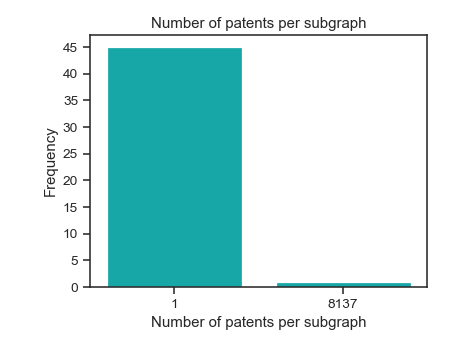

In [127]:
# Count the number of patents in each subgraph
numPatents_inSubgraph_list = list(map(lambda patents: len(patents), patents_inSubgraph_list))

# Draw a count plot
plt.figure(figsize=(5,4))

sns.countplot(x=numPatents_inSubgraph_list, color='c')
plt.ylabel('Frequency')
plt.xlabel('Number of patents per subgraph')
plt.title('Number of patents per subgraph')
plt.yticks(range(0, 50, 5))

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are one huge subgraph and 45 small subgraphs. The small subgraphs have only one component, that is, each subgraph is composed of one patent. They don't have any neighbor patents, and it's impossible to extract the applications from the neighbors. On the other hand, all patents are connected by 'C08L 101/16.' Then, in the case, recommended applications will be extracted from patents having the most similar abstract. 

### 4.3. Create a recommendation system

Finally, create a recommendation system. I make 2 versions of the recommendation systems. The first one accepts one patent from a user and recommends up to 10 applications. The second one accepts 2 IPC codes from a user and recommends up to 10 applications.

4.3.1. Create a recommendation system accepting one patent as an input  
4.3.2. Create a recommendation system accepting 2 IPC codes as an input

#### 4.3.1. Create a recommendation system accepting one patent as an input

When a user already published a patent in the biodegradable polymer field and wants to know other potential applications for their polymer, this recommendation system would be used. The patent a user inputted should be in the data. For example, suppose that Company_A published Patent_1 about a biodegradable suture using polyglycolide, and they want to know that their polyglycolide could be used for the other applications. They would input Patent_1 in the system and would get 10 potential applications. Also, the patent could be a competitor's patent. 

This is the flow:  <img src="system_1.png" width="700px">

First, define some functions that will be repeatedly used.

Define a function that prints the recommended applications and the reference patents (the result.)

Next, define the function that runs the recommendation system that accepts one patent and recommend up to 10 pat

In [459]:
def print_applications_references(appIpc_refPatents):
    '''
    Print up to 10 applications and the reference patents when the dictionary (appIpc_refPatents) is given. 
    ''' 
    # Print recommended application codes and the reference patents
    print('Recommended application codes and the reference patents:')
    print('-------------------------------------------------------------------------------------------------------------')
    print(pd.DataFrame({'Application IPC Code': list(appIpc_refPatents.keys()),
                        'Reference Patent': list(appIpc_refPatents.values())}))
    print('-------------------------------------------------------------------------------------------------------------')
    print('')
                            
    # Make a new DataFrame of the reference patents
    df_references = pd.DataFrame(columns=df.columns)
    
    # Get the patents as a set
    ref_patents = set()
    for v in appIpc_refPatents.values():
        if type(v) == str:
            ref_patents.add(v)
        else:
            ref_patents = ref_patents.union(v)
    
    # Extract the patent information
    for ref in ref_patents:
        if ref not in list(df_references['Patent_Id']):
                df_references = df_references.append(df[df['Patent_Id'] == ref])
    
    # Print the titles of the reference patents
    print('The reference patents:')
    print('-------------------------------------------------------------------------------------------------------------')
    print(df_references[['Patent_Id', 'Application_Date', 'Title']].str.ljust)
    print('-------------------------------------------------------------------------------------------------------------')
    print('..............................................................................................................')

Next, define the function that runs the recommendation system that accepts one patent and recommend up to 10 applications.

In [447]:
# Recommend applications from one patent
def recommend_app_from_patent(patent_id):
    '''
    Recommend up to 10 applications when one patent ID (patent_id) is given by a user. 
    The input patent should be included in the original data.
    ''' 
    # Print the patent ID a user inputted
    print('..............................................................................................................')
    print('Patent ID you inputted:', patent_id)
    print('')
    
    # Check if the patent ID is in the system
    if patent_id not in list(G_patents.nodes()):
        print('** Error **')
        print('The patent ID is not acceptable.')
        print('Check the format (e.g., "JP272810309"), use the other patent, or use IPC codes instead. [Error1]')
    else:
        neighbor_patents = set(G_patents.neighbors(patent_id))
        # For counting patents checked
        checked_patents = set([patent_id])
        # For counting IPC codes checked
        checked_ipcs = set(G.neighbors(patent_id))
        # For collecting reference patents and application IPC codes (this is what we want)
        appIpc_refPatents = {}
        
        # To check if the warning has been raised
        raised_warning2 = False
        raised_warning3 = False
        
        # Continue the loop until getting 10 recommended applications
        while len(appIpc_refPatents) < 10:

            # For tempolaly keeping patent IDs and the similarities
            id_simi = {}
            
            # Get similar patents from the similarities when there is no neighbor
            if len(neighbor_patents) == 0:
                if patent_id in df_similarities.columns:
                    print('** Rough estimate **')
                    print('No neighbor patent [Warning1]')
                    patents_simi_order = df_similarities.loc[patent_id].sort_values(ascending=False).index
                    print('')

                # Show the error message when patent_id is not in df_similarities
                else: 
                    print('** Error **')
                    print('The patent ID is not acceptable.')
                    print('Use the other patent, or use IPC codes instead. [Error2]')
                    break
            else:            
                if patent_id in df_similarities.columns:
                    # Get the similarities of the neighbor patents
                    for patent1 in neighbor_patents:
                        if patent1 in df_similarities.columns:
                            id_simi[patent1] = df_similarities.loc[patent_id, patent1]
                        # Get the mean as the similarity when patent1 doesn't have the similarity
                        else:
                            id_simi[patent1] = df_similarities.loc[patent_id].mean()
                    
                    # Sort the dictionary by the similarities
                    id_simi_sorted = sorted(id_simi.items(), key=lambda x: x[1], reverse=True)
                    # Get the patent IDs
                    patents_simi_order = list(map(lambda tup: tup[0], id_simi_sorted))
                else:
                    # Show these message only once
                    if raised_warning2 == False:
                        print('** Rough estimate **')
                        print(patent_id, "doesn't have an English or Japanese abstract [Warning2]")
                        print('')
                        raised_warning2 = True
                    patents_simi_order = list(neighbor_patents)
            
            # Get application IPC codes of the neighbor patents
            for patent2 in patents_simi_order:
                checked_patents.add(patent2)
                nei_ipc = set(G.neighbors(patent2)) - checked_ipcs
                
                # Break flag
                break_loop = False
                
                # Search the IPC codes
                for ipc in nei_ipc:
                    checked_ipcs.add(ipc)
                    # Get the IPC code if it is an application IPC code
                    if ipc[:3] in app_count_dict.keys():
                        appIpc_refPatents[ipc] = patent2
                        # Stop the search if we already have 10 recommended applications
                        if len(appIpc_refPatents) == 10:
                            break_loop = True
                            # Print the applications and the references 
                            print_applications_references(appIpc_refPatents)
                            break
                            
                if break_loop:
                    break
                    
            # Get the neighbor patents of the neighbor patents
            if len(appIpc_refPatents) < 10:
                # Show these message only once
                if raised_warning3 == False:
                    # Print warning
                    print('** Rough estimate **')
                    print('The second-tiers after', len(appIpc_refPatents), '[warning3]')
                    print('')
                    raised_warning3 = True
                
                # Because neighbor_patents will be modufied for next loop
                neighbor_patents_iter = list(neighbor_patents)
                neighbor_patents = set()
                
                # Get the neighbor patents of the neighbor patents
                for patent3 in neighbor_patents_iter:
                    neighbor_patents = neighbor_patents.union(set(G_patents.neighbors(patent3)))
                    
                neighbor_patents = neighbor_patents - checked_patents

Check the time taken and the example of the output to confirm this system works appropriately. Try the system several times.

In [449]:
%%time

# Example 1
patent = random.choice(df['Patent_Id'])
recommend_app_from_patent(patent)

..............................................................................................................
Patent ID you inputted: ES5742661

** Rough estimate **
ES5742661 doesn't have an English or Japanese abstract [Warning2]

Recommended application codes and the reference patents:
----------------------------------------
  Application IPC Code Reference Patent
0           E01C 13/08      KR214791085
1            A23L 1/31       US40486355
2           A01G 13/00       US40486355
3            A01G 9/02       US40486355
4           A61K 47/26        BR6245501
5           C12N 15/09        BR6245501
6            C12N 5/10        BR6245501
7           A61K 48/00        BR6245501
8           A61P 35/00        BR6245501
9           A61K 35/14        BR6245501
----------------------------------------

The reference patents:
-------------------------------------------------------------------------------------------------------------
        Patent_Id Application_Date  \
5667    BR62455

The system returned 10 applications and a message when it is appropriate. It took less than 100 ms. It would be fast enough.  
  
Next, try special cases: a non-existent patent (example 2), a no-neighbor patent (example 3), and a non-English or Japanese abstract (example 4). 

In [450]:
# Example 2 (special case): a non-existent patent
print('Example 2: a non-existent patent')
patent = 'JP273436361'
recommend_app_from_patent(patent)

Example 2: a non-existent patent
..............................................................................................................
Patent ID you inputted: JP273436361

** Error **
The patent ID is not acceptable.
Check the format (e.g., "JP272810309"), use the other patent, or use IPC codes instead. [Error1]


In [451]:
# Example 3 (special case): a no-neighbor patent (one component in a subgraph)
print('Example 3: a non-existent patent')
patent = 'ID202886819'
recommend_app_from_patent(patent)

Example 3: a non-existent patent
..............................................................................................................
Patent ID you inputted: ID202886819

** Error **
The patent ID is not acceptable.
Use the other patent, or use IPC codes instead. [Error2]


In [452]:
# Example 4 (special case): a non-English or Japanese abstract
print('Example 4: a non-English or Japanese abstract')
patent = 'AU194053523'
recommend_app_from_patent(patent)

Example 4: a non-English or Japanese abstract
..............................................................................................................
Patent ID you inputted: AU194053523

** Rough estimate **
AU194053523 doesn't have an English or Japanese abstract [Warning2]

** Rough estimate **
The second-tiers after 8 [warning3]

Recommended application codes and the reference patents:
----------------------------------------
  Application IPC Code Reference Patent
0           A01N 43/64       US36888018
1          A23K 20/195      GB135682664
2            A23K 1/18       US40877941
3           A01K 97/04       US40877941
4            A23K 1/20       US40877941
5           A01K 85/00       US40877941
6           A23K 1/165       US40877941
7            C12P 7/62      JP271092186
8            C12N 1/20       US36772626
9            A23L 1/31       US40486355
----------------------------------------

The reference patents:
-------------------------------------------------------

These examples caused an appropriate error or warning.  

(I will add Unit Test here: The system works to all of the patents in the data. Show an appropriate error if needed.)

#### 4.3.2. Create a recommendation system accepting 2 IPC codes as an input

When a user does not have any target patent and wants to search for some applications from IPC codes, this second recommendation system would be used. The IPC codes inputted by a user should be in the data.  
  
For example, suppose that CompanyB is developing a biodegradable suture using polyglycolide (they do not have the patent yet), and wants to know other potential applications for their polymer. They would search the IPC codes of polyglycolide (C08G 63/06) and a biodegradable suture (A61L 17/06, A61L 17/08, or A61L 17/12 (IPC is a hierarchic structure. I recommend to try several IPC codes that are related to what you want to search).) Then, they input 2 IPC codes (e.g. C08G 63/06 and A61L 17/08) into the system and would get up to 10 potential applications.  

This is the flow:  <img src="system_2.png" width="700px">

In [453]:
# Recommend applications from one patent
def recommend_app_from_2ipcs(ipc1, ipc2):
    '''
    Recommend up to 10 applications when two IPC codes (ipc1 and ipc2) are given. 
    The IPC codes should be included in the original data.
    ''' 
    # Print the IPC codes a user inputted
    print('..............................................................................................................')
    print('IPC codes you inputted:', ipc1, ',', ipc2)
    print('')
    
    # Check if the IPC codes are in the system
    if ipc1 not in list(G.nodes()):
        print('** Error **')
        print(ipc1, 'is not acceptable.')
        print('Check the format (e.g., "C08L 101/16") or use the other IPC codes instead. [Error1]')
    elif ipc2 not in list(G.nodes()):
        print('** Error **')
        print(ipc2, 'is not acceptable.')
        print('Check the format (e.g., "C08L 101/16") or use the other IPC codes instead. [Error2]')
        
    else:
        # For counting IPC codes checked
        checked_ipcs = set([ipc1, ipc2])

        # Get the neighbor patents for each IPC code
        frontier_patents_1 = set(G.neighbors(ipc1))
        frontier_patents_2 = set(G.neighbors(ipc2))
        
        # To keep patents close to each IPC code
        neighbor_patents_1 = set(frontier_patents_1)
        neighbor_patents_2 = set(frontier_patents_2)

        # Get the intersection
        intersection_12 = neighbor_patents_1 & neighbor_patents_2
                
        # To keep frontier patents
        frontiers = frontier_patents_1.union(frontier_patents_2)
        
        # Get the closest common patents
        while len(frontiers) != 0:
            
            # Go to the next step if already having common patents
            if len(intersection_12) != 0:
                break
                
            # Get the neighbor patents of the neighbor patents when intersection_12 is empty
            else:
                # To keep frontier patents temporary
                frontier_patents_1_temp = set()
                frontier_patents_2_temp = set()
                
                # Get the frontier patents
                for patent1 in frontier_patents_1:
                    frontier_patents_1_temp = frontier_patents_1_temp.union(set(G_patents.neighbors(patent1)))
                for patent2 in frontier_patents_2:
                    frontier_patents_2_temp = frontier_patents_2_temp.union(set(G_patents.neighbors(patent2)))
                
                # Only get new patents as frontier_patents
                frontier_patents_1 = frontier_patents_1_temp - neighbor_patents_1
                frontier_patents_2 = frontier_patents_2_temp - neighbor_patents_2
                
                # Keep the new patents in each IPC code group
                neighbor_patents_1 = neighbor_patents_1.union(frontier_patents_1)
                neighbor_patents_2 = neighbor_patents_2.union(frontier_patents_2)
                
                # Get the intersection
                intersection_12 = neighbor_patents_1 & neighbor_patents_2
                
                # Combine frontier_patens_1 and _2
                frontiers = frontier_patents_1.union(frontier_patents_2)
        

        # Show the error if we couldn't find any common patent, and end the searching
        if len(frontiers) == 0:
            print('** Error **')
            print('No connection between the two IPC codes. Try a different combination. [Error3]')
                
        else:
            # For counting patents checked
            checked_patents = set()
            
            # For collecting reference patents and application IPC codes (this is what we want)
            appIpc_refPatents = {}
            
            # To check if the warning has been shown
            warning_appear = False
        
            # Continue the loop until getting 10 recommended applications
            while len(appIpc_refPatents) < 10:
                # Get application IPC codes of the neighbor patents
                nei_ipc = []
                
                for patent3 in intersection_12: 
                    checked_patents.add(patent3)
                    nei_ipc.extend(set(G.neighbors(patent3)) - checked_ipcs)
                    
                # Count each IPC code
                nei_ipc_count = Counter(nei_ipc)
                
                # Sort the dictionary by the frequency
                nei_ipc_count_sorted = sorted(nei_ipc_count.items(), key=lambda x: x[1], reverse=True)
                
                # Get the IPC codes
                nei_ipc_sorted = list(map(lambda tup: tup[0], nei_ipc_count_sorted))
                    
                # Break flag
                break_loop = False
                
                # Check the IPC codes of the intersection patents to find applications
                for ipc in nei_ipc_sorted:
                    checked_ipcs.add(ipc)
                    
                    # Get the IPC code if it is an application IPC code
                    if ipc[:3] in app_count_dict.keys():
                        appIpc_refPatents[ipc] = set(G.neighbors(ipc)) & intersection_12
                        
                        # Stop the search if we already have 10 recommended applications
                        if len(appIpc_refPatents) == 10:
                            break_loop = True
                            print_applications_references(appIpc_refPatents)
                            break
                                 
                if break_loop:
                    break
                
                # Get the neighbor patents of neighbor patents
                if len(appIpc_refPatents) < 10:
                    # Because intersection_12 will be modified for next loop
                    intersection_12_temp = list(intersection_12)
                    intersection_12 = set()
                        
                    for patent4 in intersection_12_temp:
                        intersection_12 = intersection_12.union(set(G_patents.neighbors(patent4)))
                        
                    intersection_12 = intersection_12 - checked_patents
                    
                    if len(intersection_12) != 0:
                        
                        if warning_appear == False:
                            # Print warning
                            print('** Rough estimate **')
                            print('The second-tiers after', len(appIpc_refPatents), '[warning]')
                            print('')
                            warning_appear = True
                        
                        # For temporary keeping patent IDs and the similarities
                        id_simi = dict([(i,0) for i in intersection_12])
                    
                        for patent5 in intersection_12_temp:
                            
                            if patent5 in df_similarities.columns:
                                # Get the similarities of the neighbor patents
                                for patent6 in intersection_12:
                                    if patent6 in df_similarities.columns:
                                        if id_simi[patent6] < df_similarities.loc[patent5, patent6]:
                                            id_simi[patent6] = df_similarities.loc[patent5, patent6]
                                    # Get the mean as the similarity when the patent doesn't have the similarity
                                    else:
                                        id_simi[patent6] = df_similarities.loc[patent5].mean()
                    
                        # Sort the dictionary by the similarities
                        id_simi_sorted = sorted(id_simi.items(), key=lambda x: x[1], reverse=True)
                        # Get the top 10 similar patents and assign them as intersection_12
                        intersection_12 = set(list(map(lambda tup: tup[0], id_simi_sorted))[:10])
                            
                    else:
                        print_applications_references(appIpc_refPatents)
                        break

Check the time taken and the example of the output to confirm this system works appropriately. Try the system several times.

In [454]:
%%time

# Example 1
ipcs = random.sample(list(ipc_freq.keys()), 2)
recommend_app_from_2ipcs(ipcs[0], ipcs[1])

..............................................................................................................
IPC codes you inputted: A61K 39/002 , E05D 1/00

Recommended application codes and the reference patents:
----------------------------------------
  Application IPC Code                                   Reference Patent
0           A61K 47/36  {JP271089404, US42041915, JP289824828, BR6245501}
1            A61K 9/14             {WO2003039615, US42041915, US40722703}
2            A61F 2/00                         {WO2003039615, US40722703}
3           A61L 27/14                         {WO2003039615, US40722703}
4            F16L 1/00                         {WO2003039615, US40722703}
5           A61L 27/56                         {WO2003039615, US40722703}
6            A61F 2/04                         {WO2003039615, US40722703}
7           A61L 27/00                         {WO2003039615, US40722703}
8           C12N 15/09                            {US42041915, BR6245501}
9 

The system returned 10 applications and a message when it was appropriate. It took only 2 seconds even if it took longer. It would be acceptable.

Next, try special cases: a non-existent IPC code (example 2), no connection between two IPC codes (example 3), no intersection in the first cycle (example 4)

In [455]:
# Example 2 (special case): a non-existent IPC code
print('Example 2: a non-existent IPC code')
# 'C08H 10/20' doesn't exist in the data
ipc1 = 'A45D 40/20'
ipc2 = 'C08H 10/20'
recommend_app_from_2ipcs(ipc1, ipc2)

Example 2: a non-existent IPC code
..............................................................................................................
IPC codes you inputted: A45D 40/20 , C08H 10/20

** Error **
C08H 10/20 is not acceptable.
Check the format (e.g., "C08L 101/16") or use the other IPC codes instead. [Error2]


In [456]:
# Example 3 (special case): no connection between two IPC codes
print('Example 3: no connection between two IPC codes')
ipc1 = 'B32B 15/06'
ipc2 = 'A61K 31/727'
recommend_app_from_2ipcs(ipc1, ipc2)

Example 3: no connection between two IPC codes
..............................................................................................................
IPC codes you inputted: B32B 15/06 , A61K 31/727

** Error **
No connection between the two IPC codes. Try a different combination. [Error3]


In [457]:
# Example 4 (special case): no intersection in the first cycle
print('Example 3: no intersection in the first cycle')
ipc1 = 'B65D 77/30'
ipc2 = 'A62C 13/66'
recommend_app_from_2ipcs(ipc1, ipc2)

Example 3: no intersection in the first cycle
..............................................................................................................
IPC codes you inputted: B65D 77/30 , A62C 13/66

** Rough estimate **
The second-tiers after 0 [warning]

Recommended application codes and the reference patents:
----------------------------------------
  Application IPC Code            Reference Patent
0           A61F 13/26  {JP271811257, JP273590701}
1            G03C 3/00               {JP269486489}
2            C02F 3/34               {JP269325601}
3           C12N 11/02               {JP269325601}
4            C02F 3/28               {JP269325601}
5            C02F 3/10               {JP269325601}
6            A01G 1/12               {JP270010929}
7            E02B 3/04               {JP270010929}
8           A01G 13/00               {JP270010929}
9            A01G 9/02               {JP270010929}
----------------------------------------

The reference patents:
-------------

These examples caused an appropriate error or warning.

(I will add Unit Test here: The system works to random 100 IPC code combinations. Show an appropriate error if needed.)

## 5. Recommend Applications (using the model)

In this section, the system to use the recommendation system is create.

### 5.1. Use the first recommendation system

The following cell accepts input from a user. A user inputs one patent ID, and the system will return the applications.

In [ ]:
# Accept input from a user
user_input = input('Input a patent ID (e.g., JP273590701):')

# Run the recommendation system
recommend_app_from_patent(user_input)

**< Example >**  
Explore the system about one patent as an example. Here, I would like to pick up 'JP274783873'. Check the patent.

In [427]:
# Show 'JP274783873'
df[df['Patent_Id'] == 'JP274783873']

,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
100,JP274783873,2018097974,22.05.2018,JP,POLYMER COMPOSITION CONTAINING PLLA AND PDLA,"<p>PROBLEM TO BE SOLVED: To provide a polymer having high heat resistant shape stability, biodegradability, and based on an organism-derived raw material and a molded article obtained from the polymer.</p><p>SOLUTION: There is provided a polymer composition containing following components, a. 15 to 70 wt.% of PLLA, b. 0.1 to 15 wt.% of PDLA, c. 5 to 40 wt.% of polyester and d. 5 to 40 wt.% of an organic or inorganic filler, based on total weight of the polymer composition. Such kind of polymer composition can be biodegradated, mainly can contain bio-based carbon and can have high heat resistance. Further such kind of polymer composition can be used in a special method for manufacturing a molded article, a film or a fiber, and the molded article, the film or the fiber can be used as a container for a coffee service system because they are high in heat resistant shape stability.</p><p>SELECTED DRAWING: Figure 1</p><p>COPYRIGHT: (C)2018,JPO&INPIT</p>",C08L 67/04; C08K 3/013; C08L 67/02; C08J 5/00; C08J 5/18; C08L 101/16; D01F 6/62,BIO-TEC BIOLOGISCHE NATURVERPACKUNGEN GMBH & CO KG; バイオ－テック ビオローギッシュ ナチューフェアパックンゲン ゲーエムベーハー ウント コンパニ カーゲー,SCHMIDT HARALD; ハラルド シュミット; CHRISTOPH HESS; クリストフ へース; WOLFGANG FRIEDEK; ウルフガング フリーデク; BECKMANN RALF; ラルフ ベックマン


This patent is about a polylactic acid composition having heat-resistance property. According to the abstract, the polymer can be used as a container for a coffee service system. Use the recommendation system and get the potential applications.

In [458]:
# Accept input from a user
user_input = input('Input a patent ID (e.g., JP273590701):')

# Input 'JP274783873'

# Run the recommendation system
recommend_app_from_patent(user_input)

Input a patent ID (e.g., JP273590701):JP274783873
..............................................................................................................
Patent ID you inputted: JP274783873

Recommended application codes and the reference patents:
----------------------------------------
  Application IPC Code Reference Patent
0            A61J 3/07      JP274736750
1           A61L 27/00      JP271388842
2           A61L 17/00      JP271388842
3            A61F 2/84      JP271388842
4           A01G 13/02      JP270713333
5            A01G 9/14      JP270713333
6            A01G 9/10       EP13094850
7            B27N 5/00       EP13094850
8            B27N 3/02       EP13094850
9            A61K 6/10       US39070606
----------------------------------------

The reference patents:
-------------------------------------------------------------------------------------------------------------
        Patent_Id Application_Date  \
3220  JP271388842       30.11.2006   
4691  JP27071

### 5.2. Use the second recommendation system

The following cell accepts input from a user. A user inputs two IPC codes, and the system will return the applications.

In [ ]:
# Accept input from a user
user_input_1 = input('Input the first IPC code (e.g., A61J 3/07):')
user_input_2 = input('Input the second IPC code (e.g., A61J 3/07):')

# Run the recommendation system
recommend_app_from_2ipcs(user_input_1, user_input_2)

**< Example >**  
Explore the system about one case as an example. Here, I would like to pick up 'C08L 1/00' and 'A01G9/02'. Check the patent.

Coming soon!